<a href="https://colab.research.google.com/github/envirodatascience/final-project-wildfire/blob/main/merged_draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wildfires in the United States

This project examines the landscape of wildfires in the US from 1984-2024. We aim to answer the following questions using data from the US Geological Service that monitors trends in burn severity over this time period:

1) How has wildfire frequency changed over time in the US?

2) How has wildfire severity changed over time in the US?

3) Is prescribed burning an effective policy for mitigating fires?

4) How are individual states experiencing change in wildfire occurence?

First We Prepare our Data

In [ ]:
# import standard packages
import pandas as pd
import numpy as np

#import plotting packages
import geopandas as gpd
from plotnine import *
import plotnine

#import stats packages
import scipy.stats as stats
import statsmodels.api as sm

#import animation packages
import matplotlib.pyplot as plt
import io
import os
from PIL import Image as PILImage
from IPython.display import display, Image
import imageio


# Upload Data
We are pulling data from The Monitoring Trends in Burn Severity (MTBS) Program provided by the USGS and USDA Forest Service

The data provides info regarding all currently inventoried fires occurring between calendar year 1984 and 2024 for CONUS, Alaska, Hawaii, and Puerto Rico.

In [ ]:
# mount to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#upload fire severity data
! unzip /content/drive/MyDrive/mtbs_perims_DD.zip #unpacks zipped folder


Archive:  /content/drive/MyDrive/mtbs_perims_DD.zip
replace mtbs_perims_DD.cpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: mtbs_perims_DD.cpg      
replace mtbs_perims_DD.dbf? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: mtbs_perims_DD.dbf      y

replace mtbs_perims_DD.prj? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: mtbs_perims_DD.prj      
replace mtbs_perims_DD.sbn? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: mtbs_perims_DD.sbn      
replace mtbs_perims_DD.sbx? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: mtbs_perims_DD.sbx      
replace mtbs_perims_DD.shp? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: mtbs_perims_DD.shp      y
y
y

replace mtbs_perims_DD.shp.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: mtbs_perims_DD.shp.xml  
replace mtbs_perims_DD.shx? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: mtbs_perims_DD.shx      
replace mtbs_perims_DD_ISO_metadata.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: mt

In [ ]:
#read in shape file
shape = "mtbs_perims_DD.shp"
df = gpd.read_file(shape)

#Orienting and Data Cleaning

In [ ]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 30331 entries, 0 to 30330
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Event_ID    30331 non-null  object        
 1   irwinID     6264 non-null   object        
 2   Incid_Name  30331 non-null  object        
 3   Incid_Type  30331 non-null  object        
 4   Map_ID      30331 non-null  int64         
 5   Map_Prog    30331 non-null  object        
 6   Asmnt_Type  30331 non-null  object        
 7   BurnBndAc   30331 non-null  int64         
 8   BurnBndLat  30331 non-null  object        
 9   BurnBndLon  30331 non-null  object        
 10  Ig_Date     30331 non-null  datetime64[ms]
 11  Pre_ID      22056 non-null  object        
 12  Post_ID     30331 non-null  object        
 13  Perim_ID    2878 non-null   object        
 14  dNBR_offst  30331 non-null  int64         
 15  dNBR_stdDv  30331 non-null  int64         
 16  NoData_T    30

In [ ]:
#create state column from event ID
df['State'] = df['Event_ID'].str[:2]
df['State'].unique()

array(['AK', 'AZ', 'SD', 'CA', 'WA', 'OR', 'FL', 'NV', 'CO', 'ID', 'NM',
       'UT', 'WY', 'MT', 'NE', 'AL', 'GA', 'NC', 'SC', 'LA', 'ME', 'MI',
       'MN', 'NJ', 'VA', 'NY', 'AR', 'DE', 'MS', 'ND', 'TX', 'KY', 'TN',
       'WI', 'MO', 'WV', 'MD', 'KS', 'OK', 'IN', 'IA', 'HI', 'OH', 'MA',
       'PA', 'PR', 'IL'], dtype=object)

In [ ]:
#move state column to front
df_state = df.pop('State')
df.insert(0,'State',df_state)
df.head()

,State,Event_ID,irwinID,Incid_Name,Incid_Type,Map_ID,Map_Prog,Asmnt_Type,BurnBndAc,BurnBndLat,...,Perim_ID,dNBR_offst,dNBR_stdDv,NoData_T,IncGreen_T,Low_T,Mod_T,High_T,Comment,geometry
0,AK,AK6260315742119850801,None,CAMELBACK,Wildfire,4737,MTBS,Extended,4780,62.603,...,None,27,-9999,-970,-150,130,334,585,None,"POLYGON ((-157.44988 62.62182, -157.44895 62.6..."
1,AK,AK6256215664519850720,None,SUGARLOAF,Wildfire,4738,MTBS,Extended,5489,62.562,...,None,3,-9999,-970,-150,70,320,600,None,"POLYGON ((-156.69736 62.57441, -156.70027 62.5..."
2,AK,AK6547615382919850801,None,TAL NW 44,Wildfire,4739,MTBS,Extended,1491,65.476,...,None,14,-9999,-970,-150,50,275,530,None,"POLYGON ((-153.84454 65.46265, -153.84574 65.4..."
3,AK,AK6521015526519850803,None,GAL NE 48,Wildfire,4740,MTBS,Extended,1298,65.210,...,None,14,-9999,-970,-150,100,321,580,None,"POLYGON ((-155.27031 65.22507, -155.26915 65.2..."
4,AZ,AZ3178311066219850302,None,UNNAMED,Wildfire,4741,MTBS,Initial,1326,31.783,...,None,-10,-9999,-970,-150,25,152,320,Hard to delineate fire perimeter,"POLYGON ((-110.6733 31.75345, -110.67378 31.75..."


In [ ]:
#add year column
df['Year'] = df['Ig_Date'].dt.year
df.head()

,State,Event_ID,irwinID,Incid_Name,Incid_Type,Map_ID,Map_Prog,Asmnt_Type,BurnBndAc,BurnBndLat,...,dNBR_offst,dNBR_stdDv,NoData_T,IncGreen_T,Low_T,Mod_T,High_T,Comment,geometry,Year
0,AK,AK6260315742119850801,None,CAMELBACK,Wildfire,4737,MTBS,Extended,4780,62.603,...,27,-9999,-970,-150,130,334,585,None,"POLYGON ((-157.44988 62.62182, -157.44895 62.6...",1985
1,AK,AK6256215664519850720,None,SUGARLOAF,Wildfire,4738,MTBS,Extended,5489,62.562,...,3,-9999,-970,-150,70,320,600,None,"POLYGON ((-156.69736 62.57441, -156.70027 62.5...",1985
2,AK,AK6547615382919850801,None,TAL NW 44,Wildfire,4739,MTBS,Extended,1491,65.476,...,14,-9999,-970,-150,50,275,530,None,"POLYGON ((-153.84454 65.46265, -153.84574 65.4...",1985
3,AK,AK6521015526519850803,None,GAL NE 48,Wildfire,4740,MTBS,Extended,1298,65.210,...,14,-9999,-970,-150,100,321,580,None,"POLYGON ((-155.27031 65.22507, -155.26915 65.2...",1985
4,AZ,AZ3178311066219850302,None,UNNAMED,Wildfire,4741,MTBS,Initial,1326,31.783,...,-10,-9999,-970,-150,25,152,320,Hard to delineate fire perimeter,"POLYGON ((-110.6733 31.75345, -110.67378 31.75...",1985


In [ ]:
# filter out columns not needed in analysis
df_columns = df.drop(columns=['Event_ID', 'irwinID', 'Map_ID', 'Map_Prog', 'Asmnt_Type', 'Pre_ID', 'Post_ID', 'Perim_ID', 'Comment', 'dNBR_stdDv'])
df_columns.head()

,State,Incid_Name,Incid_Type,BurnBndAc,BurnBndLat,BurnBndLon,Ig_Date,dNBR_offst,NoData_T,IncGreen_T,Low_T,Mod_T,High_T,geometry,Year
0,AK,CAMELBACK,Wildfire,4780,62.603,-157.421,1985-08-01,27,-970,-150,130,334,585,"POLYGON ((-157.44988 62.62182, -157.44895 62.6...",1985
1,AK,SUGARLOAF,Wildfire,5489,62.562,-156.645,1985-07-20,3,-970,-150,70,320,600,"POLYGON ((-156.69736 62.57441, -156.70027 62.5...",1985
2,AK,TAL NW 44,Wildfire,1491,65.476,-153.829,1985-08-01,14,-970,-150,50,275,530,"POLYGON ((-153.84454 65.46265, -153.84574 65.4...",1985
3,AK,GAL NE 48,Wildfire,1298,65.210,-155.265,1985-08-03,14,-970,-150,100,321,580,"POLYGON ((-155.27031 65.22507, -155.26915 65.2...",1985
4,AZ,UNNAMED,Wildfire,1326,31.783,-110.662,1985-03-02,-10,-970,-150,25,152,320,"POLYGON ((-110.6733 31.75345, -110.67378 31.75...",1985


In [ ]:
df_columns.describe()

,BurnBndAc,Ig_Date,dNBR_offst,NoData_T,IncGreen_T,Low_T,Mod_T,High_T,Year
count,3.033100e+04,30331,30331.000000,30331.000000,30331.000000,30331.000000,30331.000000,30331.000000,30331.000000
mean,7.076553e+03,2006-12-30 03:19:58.180000,-2671.706373,2022.287627,2617.766839,131.472421,538.656391,1686.235798,2006.574099
min,5.000000e+02,1984-01-26 00:00:00,-9999.000000,-1070.000000,-500.000000,-9999.000000,-9999.000000,-9999.000000,1984.000000
25%,1.137500e+03,1999-08-30 00:00:00,-9999.000000,-970.000000,-150.000000,40.000000,90.000000,-588.000000,1999.000000
50%,1.881000e+03,2008-03-15 00:00:00,-10.000000,-970.000000,-150.000000,70.000000,290.000000,580.000000,2008.000000
75%,4.097500e+03,2015-09-09 00:00:00,18.000000,9999.000000,9999.000000,150.000000,450.000000,9999.000000,2015.000000
max,1.068802e+06,2024-10-09 00:00:00,373.000000,9999.000000,9999.000000,785.000000,99999.000000,9999.000000,2024.000000
std,2.618539e+04,NaN,4429.035348,4885.577822,4520.870737,273.590021,6480.445412,7904.206097,10.701418


In [ ]:
# Replace -9999 with np.nan in the specific column
df_columns['dNBR_offst'] = df_columns['dNBR_offst'].replace(-9999, np.nan)
df_columns.describe()

,BurnBndAc,Ig_Date,dNBR_offst,NoData_T,IncGreen_T,Low_T,Mod_T,High_T,Year
count,3.033100e+04,30331,22215.000000,30331.000000,30331.000000,30331.000000,30331.000000,30331.000000,30331.000000
mean,7.076553e+03,2006-12-30 03:19:58.180000,5.237812,2022.287627,2617.766839,131.472421,538.656391,1686.235798,2006.574099
min,5.000000e+02,1984-01-26 00:00:00,-210.000000,-1070.000000,-500.000000,-9999.000000,-9999.000000,-9999.000000,1984.000000
25%,1.137500e+03,1999-08-30 00:00:00,-16.000000,-970.000000,-150.000000,40.000000,90.000000,-588.000000,1999.000000
50%,1.881000e+03,2008-03-15 00:00:00,5.000000,-970.000000,-150.000000,70.000000,290.000000,580.000000,2008.000000
75%,4.097500e+03,2015-09-09 00:00:00,27.000000,9999.000000,9999.000000,150.000000,450.000000,9999.000000,2015.000000
max,1.068802e+06,2024-10-09 00:00:00,373.000000,9999.000000,9999.000000,785.000000,99999.000000,9999.000000,2024.000000
std,2.618539e+04,NaN,36.040325,4885.577822,4520.870737,273.590021,6480.445412,7904.206097,10.701418


#Wildfire Dynamics over Time

We want to investigate how fire size, severity, and frequency change over time.

In [ ]:
# filter for wildfires
df_wildfires = df_columns[df_columns['Incid_Type'] == 'Wildfire']

In [ ]:
# bucket by year
df_wildfires['Ig_Date'] = pd.to_datetime(df_wildfires['Ig_Date'])
df_wildfires['Year'] = df_wildfires['Ig_Date'].dt.year
df_wildfires_years = df_wildfires.pivot_table(index = 'Year', values = 'Incid_Type', aggfunc = 'count')
df_wildfires_years = df_wildfires_years.rename(columns = {'Incid_Type': 'Wildfires'})
df_wildfires_years = df_wildfires_years.reset_index()
df_wildfires_years.head()

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Year,Wildfires
0,1984,188
1,1985,417
2,1986,281
3,1987,413
4,1988,400


Wildfire Frequency over Time

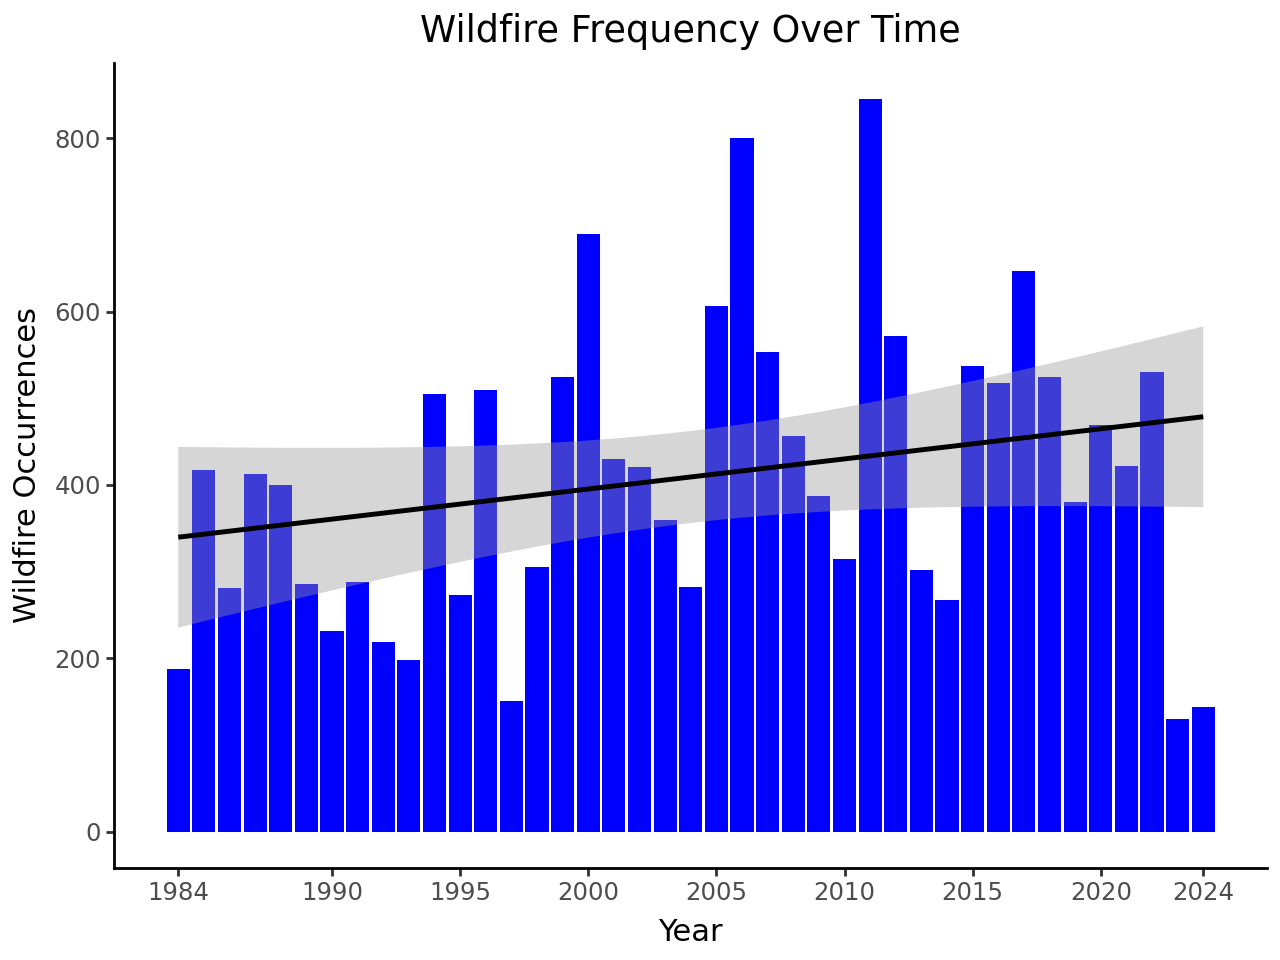

In [ ]:
# fire frequency over time
(
    ggplot(df_wildfires_years, aes(x = 'Year', y='Wildfires'))
       + geom_bar(stat = 'identity', fill = 'blue')
       + geom_smooth(method='lm')
       + xlab("Year")
       + ylab("Wildfire Occurrences")
       + ggtitle("Wildfire Frequency Over Time")
       + scale_x_continuous(breaks = [1984, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2024])
       + theme_classic()

)

In [ ]:
# year of highest fire frequency
df_wildfires_years.sort_values(by = 'Wildfires', ascending = False).head(1)

,Year,Wildfires
27,2011,845


The graph shows that the frequency of fires has trended upward over time, with a peak in 2011.

Wildfire Size over Time

In [ ]:
# aggregate burned acres per year
df_wildfires_acres = df_wildfires.pivot_table(index = 'Year', values = 'BurnBndAc', aggfunc = 'sum')
df_wildfires_acres['BurnBndAc'] = df_wildfires_acres['BurnBndAc'].astype(int)
df_wildfires_acres['BurnBndAc'] = df_wildfires_acres['BurnBndAc'] / 1000000
df_wildfires_acres = df_wildfires_acres.reset_index()
df_wildfires_acres.head()

,Year,BurnBndAc
0,1984,1.239015
1,1985,3.198033
2,1986,1.824537
3,1987,2.290434
4,1988,4.627236


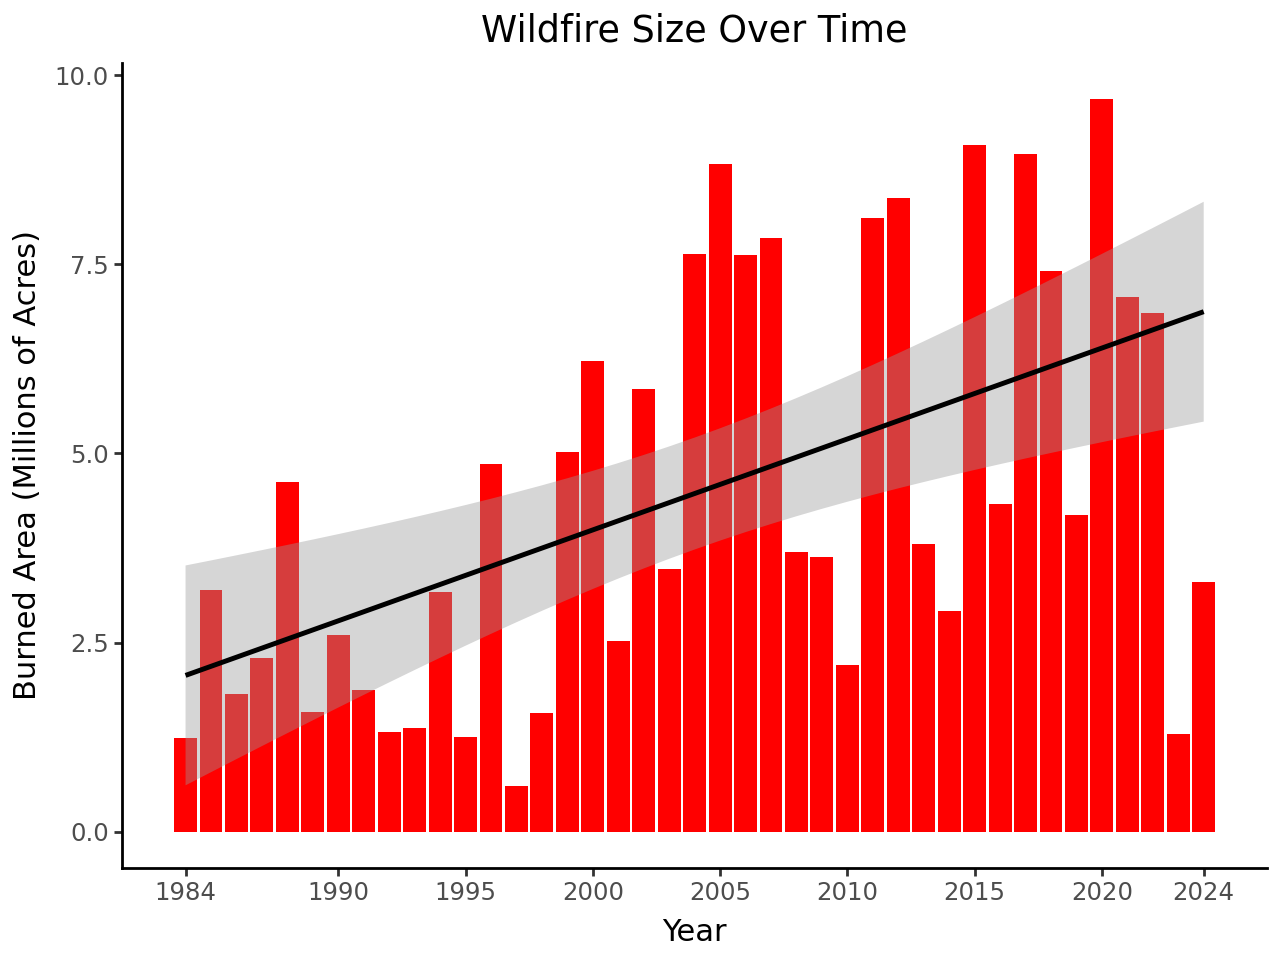

In [ ]:
# fire size over time
(
    ggplot(df_wildfires_acres, aes(x = 'Year', y='BurnBndAc'))
       + geom_bar(stat = 'identity', fill = 'red')
       + geom_smooth(method='lm')
       + xlab("Year")
       + ylab("Burned Area (Millions of Acres)")
       + ggtitle("Wildfire Size Over Time")
       + scale_x_continuous(breaks = [1984, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2024])
       + scale_y_continuous()
       + theme_classic()
)

In [ ]:
# check year of worst fires by acres burned
df_wildfires_acres.sort_values(by = 'BurnBndAc', ascending = False).head(1)

,Year,BurnBndAc
36,2020,9.68503


As the graph shows, the acres burned by wildfires has increased over time, with 2020 as the worst year for land affected by wildfires.  

# Wildfire Severity over Time

We measure wildfire severity by dNBR.

In [ ]:
#check dNBR details
df_wildfires['dNBR_offst'].describe()

,dNBR_offst
count,14088.000000
mean,6.195840
std,37.614745
min,-210.000000
25%,-16.000000
50%,5.000000
75%,28.000000
max,306.000000


In [ ]:
# aggregate dNBR per year
df_wildfires_dNBR = df_wildfires.pivot_table(index = 'Year', values = 'dNBR_offst', aggfunc = 'mean')
df_wildfires_dNBR = df_wildfires_dNBR.reset_index()
df_wildfires_dNBR.head()

,Year,dNBR_offst
0,1984,8.431579
1,1985,13.332344
2,1986,7.322176
3,1987,26.000000
4,1988,9.522152


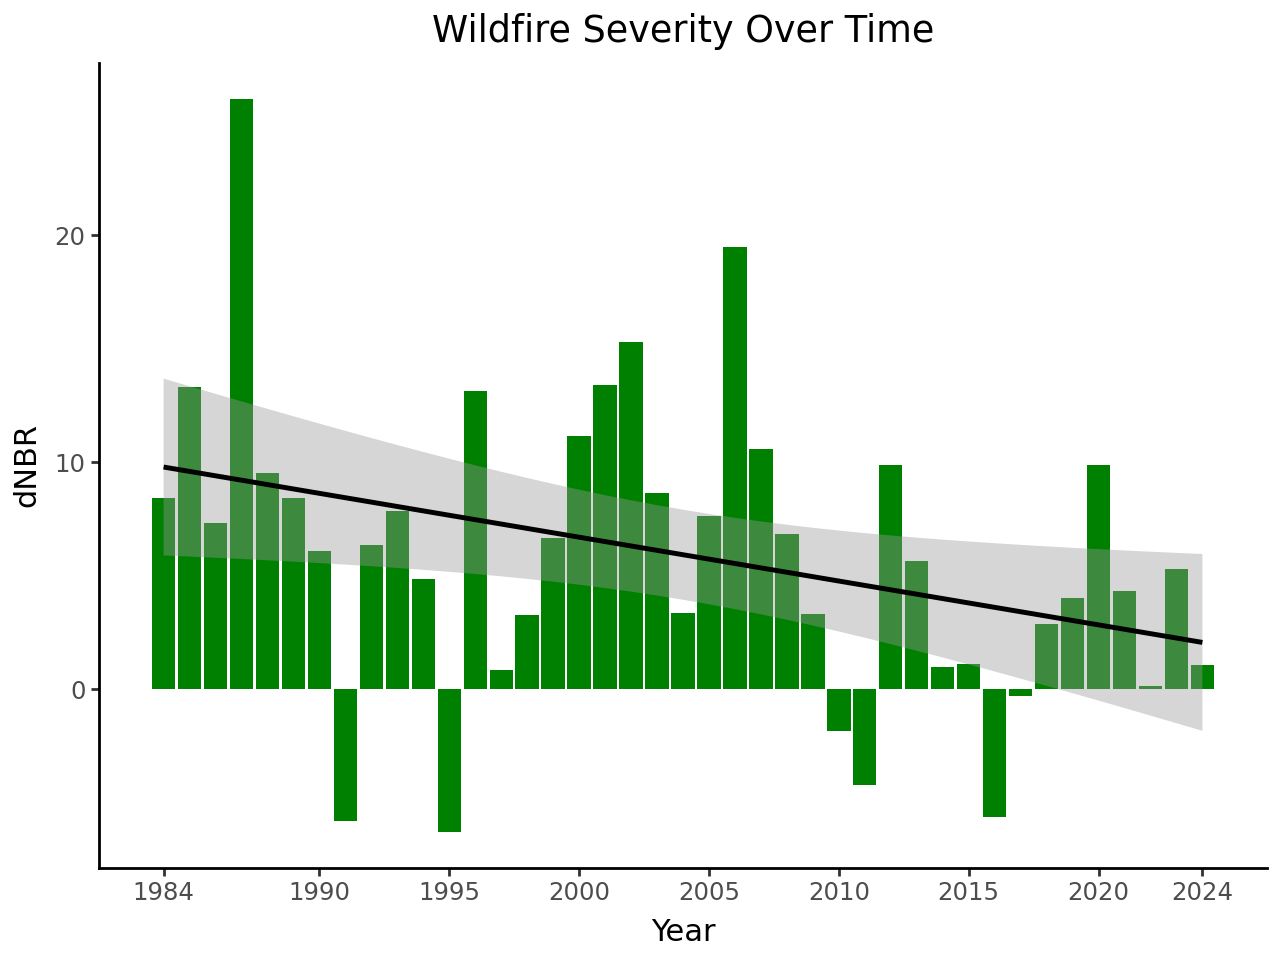

In [ ]:
# dNBR over time
(
    ggplot(df_wildfires_dNBR, aes(x = 'Year', y='dNBR_offst'))
    + geom_bar(stat = 'identity', fill = 'green')
    + geom_smooth(method='lm')
    + theme_classic()
    + xlab("Year")
    + ylab("dNBR")
    + ggtitle("Wildfire Severity Over Time")
    + scale_x_continuous(breaks = [1984, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2024])
)

#Prescribed Burns vs Wildfires over Time

How does the occurrence of prescribed burns relate to wildfires?

In [ ]:
# check potential incident types
df_columns['Incid_Type'].unique()

array(['Wildfire', 'Prescribed Fire', 'Unknown', 'Wildland Fire Use'],
      dtype=object)

In [ ]:
# filter for prescribed burns
df_prescribed = df_columns[df_columns['Incid_Type'] == 'Prescribed Fire']
df_prescribed.head()

,State,Incid_Name,Incid_Type,BurnBndAc,BurnBndLat,BurnBndLon,Ig_Date,dNBR_offst,NoData_T,IncGreen_T,Low_T,Mod_T,High_T,geometry,Year
192,CA,BEAR MTN. 4,Prescribed Fire,1473,38.156,-120.739,1985-09-17,18.0,-970,-150,100,264,475,"POLYGON ((-120.76035 38.17445, -120.7603 38.17...",1985
193,CA,BLUE MTN. WEST,Prescribed Fire,4627,40.564,-121.969,1985-08-27,-11.0,-970,-150,40,9999,9999,"POLYGON ((-121.9987 40.55225, -121.99769 40.55...",1985
360,NJ,UNNAMED,Prescribed Fire,761,39.631,-74.410,1985-03-08,NaN,9999,9999,250,20,-9999,"POLYGON ((-74.40977 39.6343, -74.41001 39.6341...",1985
361,NJ,UNNAMED,Prescribed Fire,768,39.914,-74.467,1985-03-01,NaN,9999,9999,275,-9999,-9999,"MULTIPOLYGON (((-74.44289 39.91073, -74.44268 ...",1985
362,NJ,UNNAMED,Prescribed Fire,1685,39.774,-74.784,1985-03-01,NaN,9999,9999,225,-9999,-9999,"POLYGON ((-74.79944 39.77788, -74.80007 39.778...",1985


In [ ]:
# prescribed fires by year

df_prescribed['Ig_Date'] = pd.to_datetime(df_prescribed['Ig_Date'])
df_prescribed['Year'] = df_prescribed['Ig_Date'].dt.year
df_prescribed_years = df_prescribed.pivot_table(index = 'Year', values = 'Incid_Type', aggfunc = 'count')
df_prescribed_years = df_prescribed_years.rename(columns = {'Incid_Type': 'Prescribed Fires'})
df_prescribed_years = df_prescribed_years.reset_index()
df_prescribed_years.head()


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Year,Prescribed Fires
0,1984,11
1,1985,8
2,1986,19
3,1987,7
4,1988,12


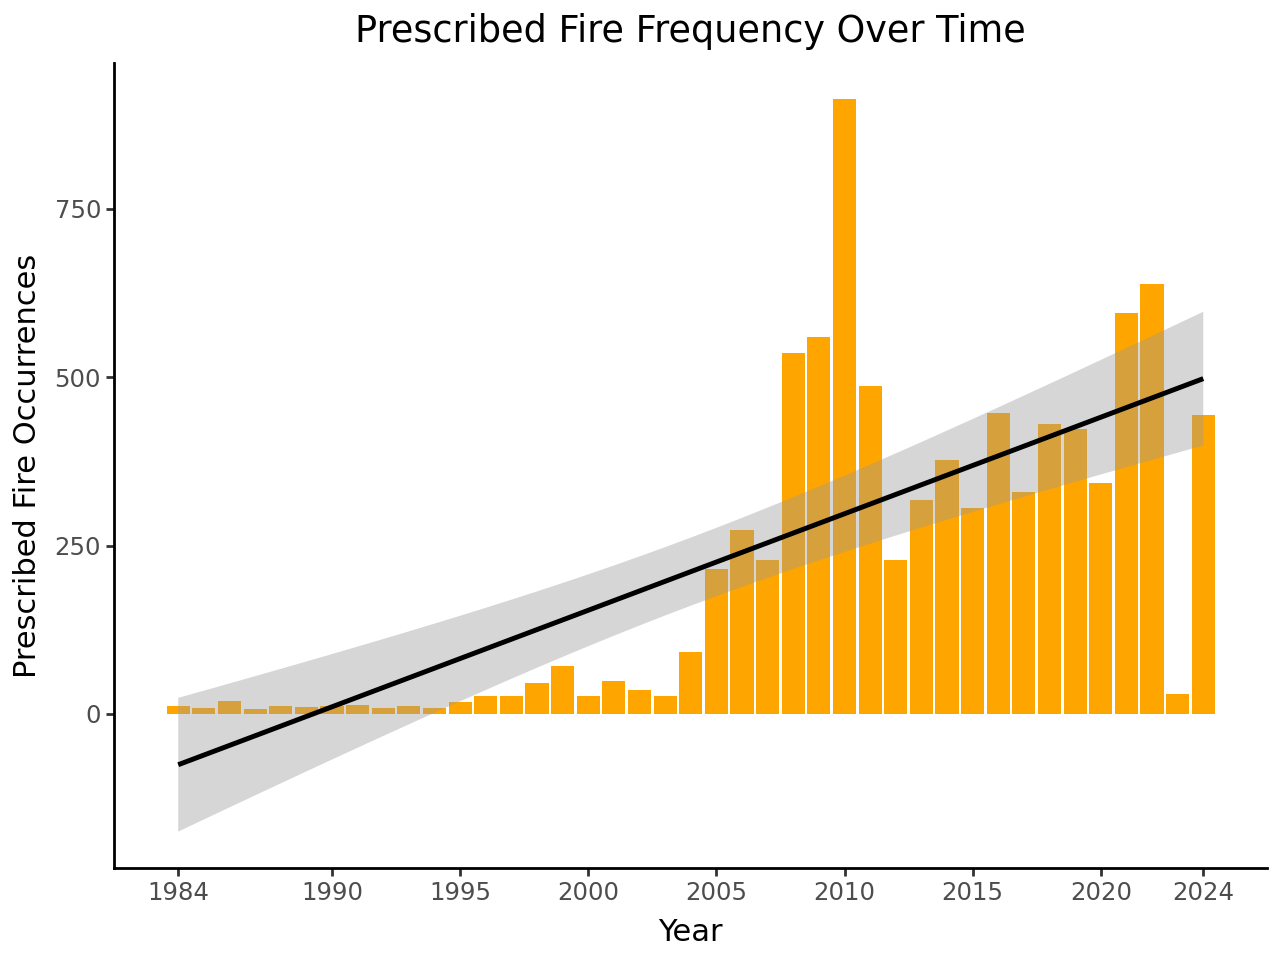

In [ ]:
# prescribed fire count over time
(
    ggplot(df_prescribed_years, aes(x = 'Year', y='Prescribed Fires'))
       + geom_bar(stat = 'identity', fill = 'orange')
       + geom_smooth(method='lm')
       + xlab("Year")
       + ylab("Prescribed Fire Occurrences")
       + ggtitle("Prescribed Fire Frequency Over Time")
       + scale_x_continuous(breaks = [1984, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2024])
       + theme_classic()
)

Now we want to look at how prescribed and wildfire trends relate over time.

In [ ]:
#merge frequency dataframes
df_freq_merged = pd.merge(df_wildfires_years, df_prescribed_years, on = 'Year')
df_freq_merged.head()

,Year,Wildfires,Prescribed Fires
0,1984,188,11
1,1985,417,8
2,1986,281,19
3,1987,413,7
4,1988,400,12


In [ ]:
# melt frequency
df_freq_melted = pd.melt(df_freq_merged, id_vars=['Year'], value_vars=['Wildfires', 'Prescribed Fires'], var_name='series', value_name='value')
df_freq_melted.head()

,Year,series,value
0,1984,Wildfires,188
1,1985,Wildfires,417
2,1986,Wildfires,281
3,1987,Wildfires,413
4,1988,Wildfires,400


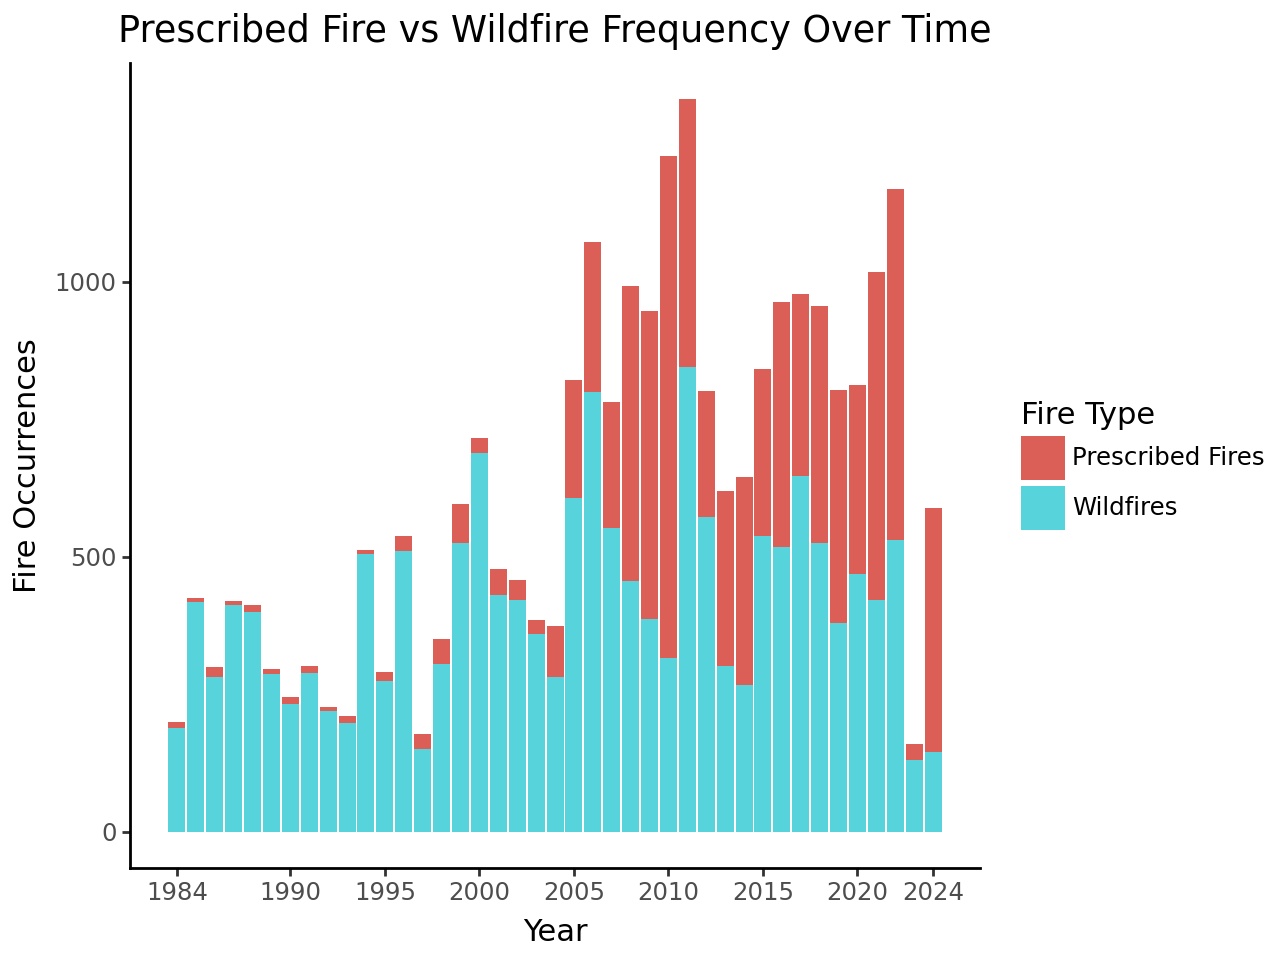

In [ ]:
# graph stacked bar chart of prescribed vs wildfires over time
(
    ggplot(df_freq_melted, aes(x = 'Year', y = 'value', fill = 'series'))
    + geom_bar(stat = 'identity')
    + xlab("Year")
    + ylab("Fire Occurrences")
    + labs(fill = 'Fire Type')
    + ggtitle("Prescribed Fire vs Wildfire Frequency Over Time")
    + scale_x_continuous(breaks = [1984, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2024])
    + theme_classic()
)


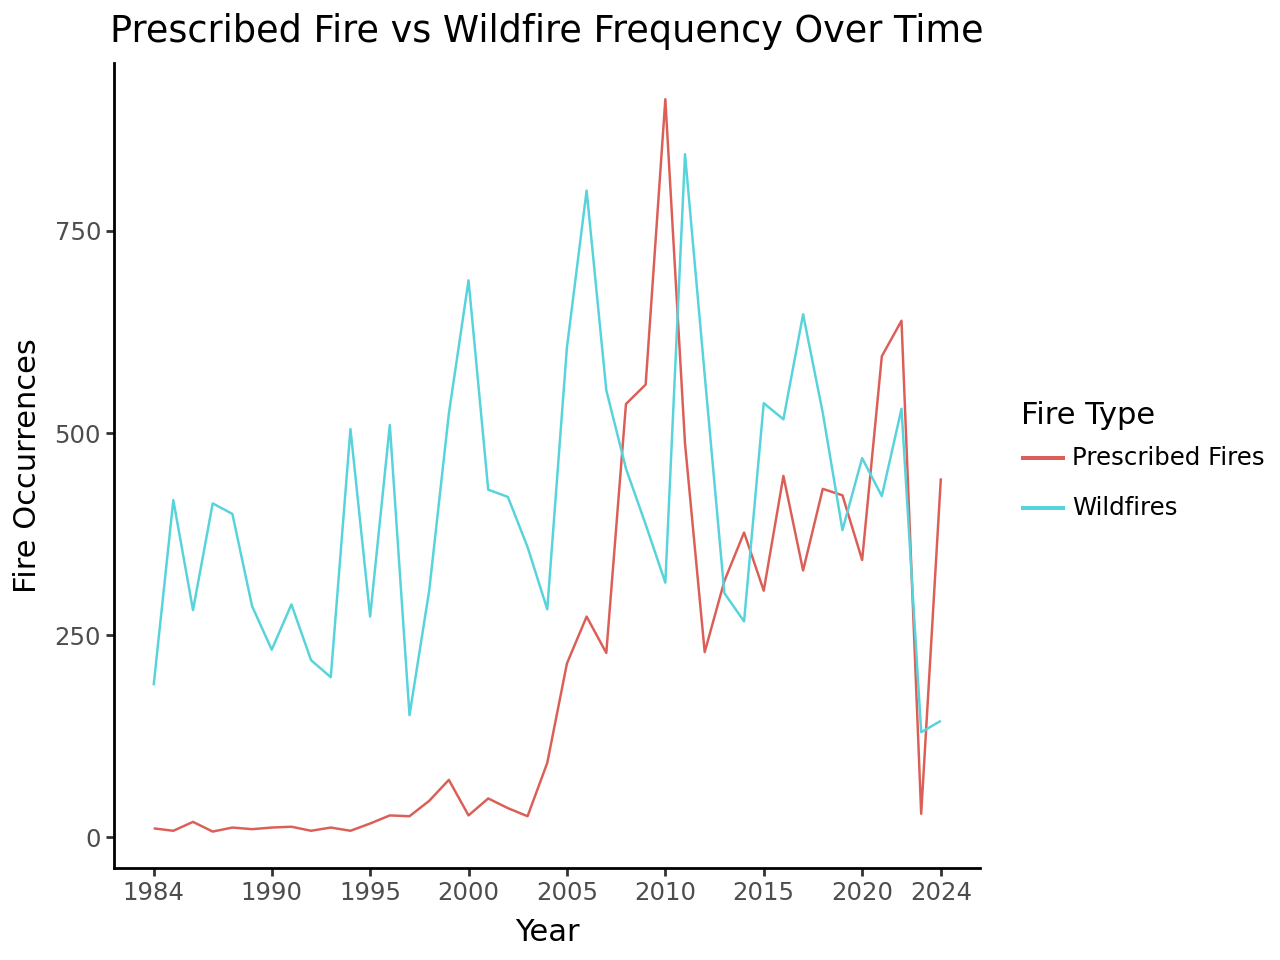

In [ ]:
# line graph of prescribed vs wildfire frequency over time
(
    ggplot(df_freq_melted, aes(x = 'Year', y = 'value', color = 'series'))
    + geom_line()
    + xlab("Year")
    + ylab("Fire Occurrences")
    + labs(color = 'Fire Type')
    + ggtitle("Prescribed Fire vs Wildfire Frequency Over Time")
    + scale_x_continuous(breaks = [1984, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2024])
    + theme_classic()
)

In [ ]:
# prescribed fires burn area
df_prescribed_acres = df_prescribed.pivot_table(index = 'Year', values = 'BurnBndAc', aggfunc = 'sum')
df_prescribed_acres['BurnBndAc'] = df_prescribed_acres['BurnBndAc'] / 1000000
df_prescribed_acres = df_prescribed_acres.reset_index()
df_prescribed_acres.head()

,Year,BurnBndAc
0,1984,0.020773
1,1985,0.024421
2,1986,0.031982
3,1987,0.010226
4,1988,0.016283


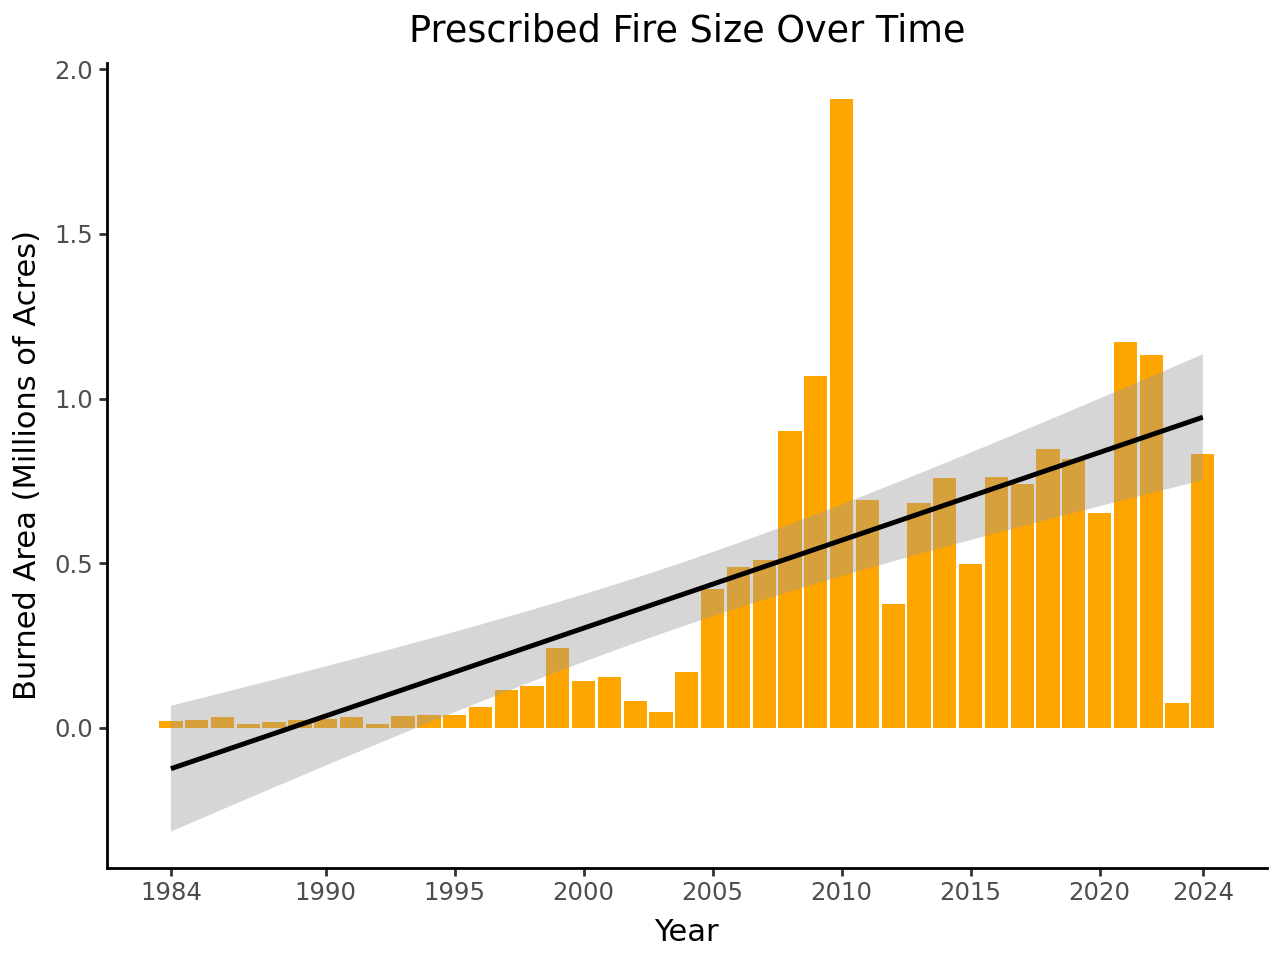

In [ ]:
# prescribed fires acres burned over time
(
    ggplot(df_prescribed_acres, aes(x = 'Year', y='BurnBndAc'))
    + geom_bar(stat = 'identity', fill = 'orange')
    + geom_smooth(method='lm')
    + xlab("Year")
    + ylab("Burned Area (Millions of Acres)")
    + ggtitle("Prescribed Fire Size Over Time")
    + scale_x_continuous(breaks = [1984, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2024])
    + scale_y_continuous()
    + theme_classic()
)

In [ ]:
# merge acres
df_acres_merged = pd.merge(df_wildfires_acres, df_prescribed_acres, on = 'Year')
df_acres_merged = df_acres_merged.rename(columns = {'BurnBndAc_x': 'Wildfires', 'BurnBndAc_y': 'Prescribed Fires'})
df_acres_merged.head()

,Year,Wildfires,Prescribed Fires
0,1984,1.239015,0.020773
1,1985,3.198033,0.024421
2,1986,1.824537,0.031982
3,1987,2.290434,0.010226
4,1988,4.627236,0.016283


In [ ]:
# melt acres
df_acres_melted = pd.melt(df_acres_merged, id_vars=['Year'], value_vars=['Wildfires', 'Prescribed Fires'], var_name='series', value_name='value')
df_acres_melted.head()

,Year,series,value
0,1984,Wildfires,1.239015
1,1985,Wildfires,3.198033
2,1986,Wildfires,1.824537
3,1987,Wildfires,2.290434
4,1988,Wildfires,4.627236


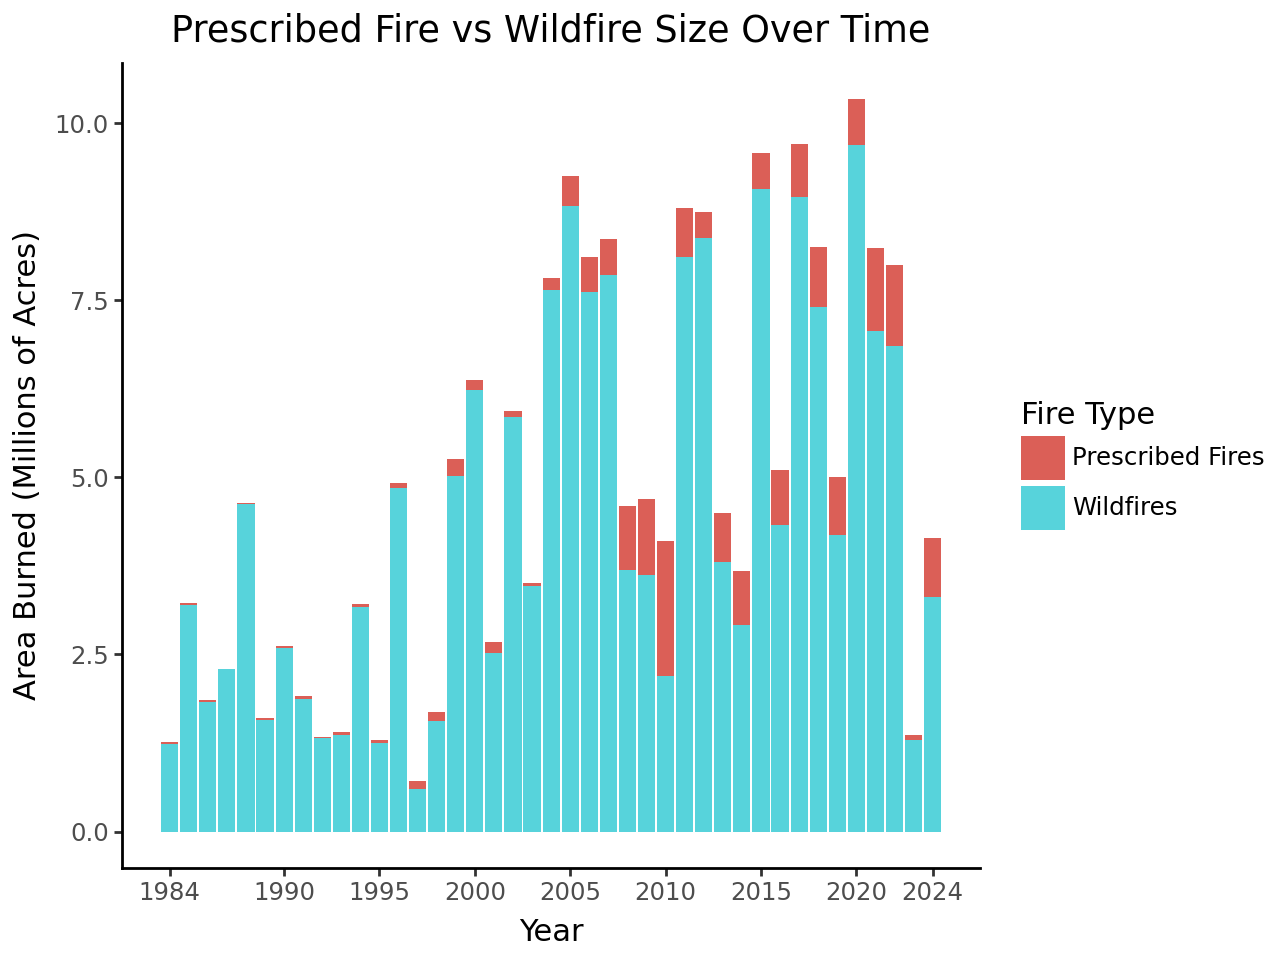

In [ ]:
# prescribed acres burned vs wildfire acres burned over time
(
    ggplot(df_acres_melted, aes(x = 'Year', y = 'value', fill = 'series'))
    + geom_bar(stat = 'identity')
    + xlab("Year")
    + ylab("Area Burned (Millions of Acres)")
    + labs(fill = 'Fire Type')
    + ggtitle("Prescribed Fire vs Wildfire Size Over Time")
    + scale_x_continuous(breaks = [1984, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2024])
    + theme_classic()
)


### State Analysis
We will take a deeper look into the three states that had the most fires during the study period.

Check state wildfire frequency

In [ ]:
# check which state has had the most wildfires in since 1984
df_wildfires['State'].value_counts().head(10).reset_index()

,State,count
0,CA,1809
1,ID,1552
2,AK,1373
3,TX,1076
4,NV,1009
5,OR,958
6,AZ,910
7,MT,890
8,FL,870
9,NM,868


In [ ]:
#check average burn size for each state
df_wildfires.groupby('State')['BurnBndAc'].mean().sort_values(ascending=False).head(10).reset_index()

,State,BurnBndAc
0,AK,28154.661326
1,OR,14258.705637
2,CA,13773.393035
3,WA,13107.172920
4,NV,12998.059465
5,GA,12946.152542
6,WY,12480.064516
7,ID,11836.476804
8,MT,10658.696629
9,NE,9120.401709


California, Alaska, and Nevada are the only three states that are in the top 5 for most wildfires and average burn size. We will zoom in on these states for more detailed analysis

In [ ]:
#load in state boundary data for individual analysis
! unzip /content/drive/MyDrive/cb_2018_us_state_500k.zip #unpacks zipped folder

Archive:  /content/drive/MyDrive/cb_2018_us_state_500k.zip
replace cb_2018_us_state_500k.shp.ea.iso.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: cb_2018_us_state_500k.shp.ea.iso.xml  
replace cb_2018_us_state_500k.shp.iso.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: cb_2018_us_state_500k.shp.iso.xml  
replace cb_2018_us_state_500k.shp? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: cb_2018_us_state_500k.shp  
replace cb_2018_us_state_500k.shx? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: cb_2018_us_state_500k.shx  
replace cb_2018_us_state_500k.dbf? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: cb_2018_us_state_500k.dbf  
replace cb_2018_us_state_500k.prj? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: cb_2018_us_state_500k.prj  
replace cb_2018_us_state_500k.cpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: cb_2018_us_state_500k.cpg  


In [ ]:
shp = "cb_2018_us_state_500k.shp"
df_states = gpd.read_file(shp) #reads in shape file
df_states.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21524, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00256 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.6432 38.16909, -82.643 38.16956,..."


In [ ]:
#Set CRS for states
df_states = df_states.to_crs(epsg=4269)

# California

We will begin by looking at fire size and frequency changes specifically in California

California Wildfire Map

In [ ]:
#call california boundary
california = df_states[df_states['NAME'] == 'California']

In [ ]:
#Zoom in on California
CA_df = df_wildfires[df_wildfires['State'] == 'CA']

CA_df.head()

,State,Incid_Name,Incid_Type,BurnBndAc,BurnBndLat,BurnBndLon,Ig_Date,dNBR_offst,NoData_T,IncGreen_T,Low_T,Mod_T,High_T,geometry,Year
13,CA,TULARE 4,Wildfire,1290,36.011,-118.797,1985-07-12,62.0,-970,-150,90,233,425,"POLYGON ((-118.78172 35.99641, -118.78252 35.9...",1985
36,CA,ADELAIDE,Wildfire,1054,35.443,-118.777,1985-05-03,2.0,-970,-150,50,300,9999,"POLYGON ((-118.7822 35.45334, -118.78119 35.45...",1985
37,CA,PONOCHE 2,Wildfire,7508,36.727,-120.768,1985-06-09,NaN,9999,9999,-30,-9999,-9999,"POLYGON ((-120.79613 36.74672, -120.79633 36.7...",1985
38,CA,LOWES,Wildfire,2708,35.903,-120.563,1985-07-02,33.0,-970,-150,140,265,450,"POLYGON ((-120.571 35.89591, -120.57104 35.895...",1985
39,CA,ONION,Wildfire,8583,36.739,-118.252,1985-07-06,-34.0,-970,-150,-50,300,9999,"POLYGON ((-118.22475 36.77746, -118.22551 36.7...",1985


In [ ]:
#Set CRS for CA data
CA_df = CA_df.to_crs(epsg=4269)

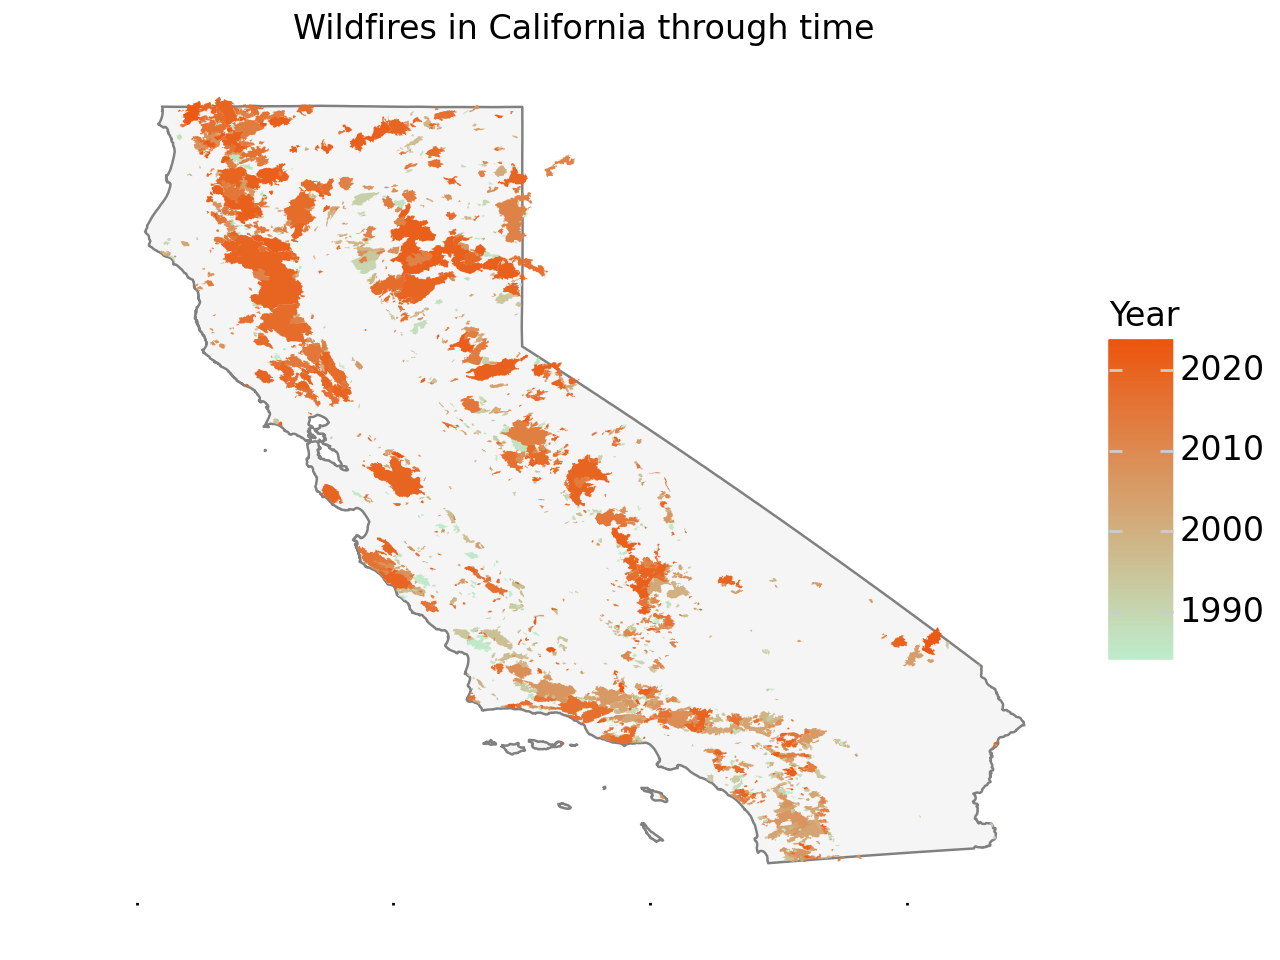

In [ ]:
#plot all CA fires according to severity
(ggplot()
  + geom_map(california, fill= 'whitesmoke', color = 'grey')
  + geom_map(CA_df, aes(geometry = 'geometry', fill = 'Year'), color = '#FF000000')
  + scale_fill_gradientn(colors = ["#beedcd", "#ed550e"],limits = [1984, 2024])
  + labs(fill='Year')
  + ggtitle("Wildfires in California through time")
  + theme_classic()
  + theme(axis_line=element_line(color="white"),
          axis_ticks=element_line(color = "white"),
          axis_text=element_line(color='white'),
          text=element_text(size = 12))
  # + xlab("")
  # + ylab("")
 )

California Wildfire Frequency

In [ ]:
# bucket by year
CA_df_years = CA_df.pivot_table(index = 'Year', values = 'Incid_Type', aggfunc = 'count')
CA_df_years = CA_df_years.rename(columns = {'Incid_Type': 'Wildfires'})
CA_df_years = CA_df_years.reset_index()
CA_df_years.head()

,Year,Wildfires
0,1984,42
1,1985,64
2,1986,29
3,1987,85
4,1988,48


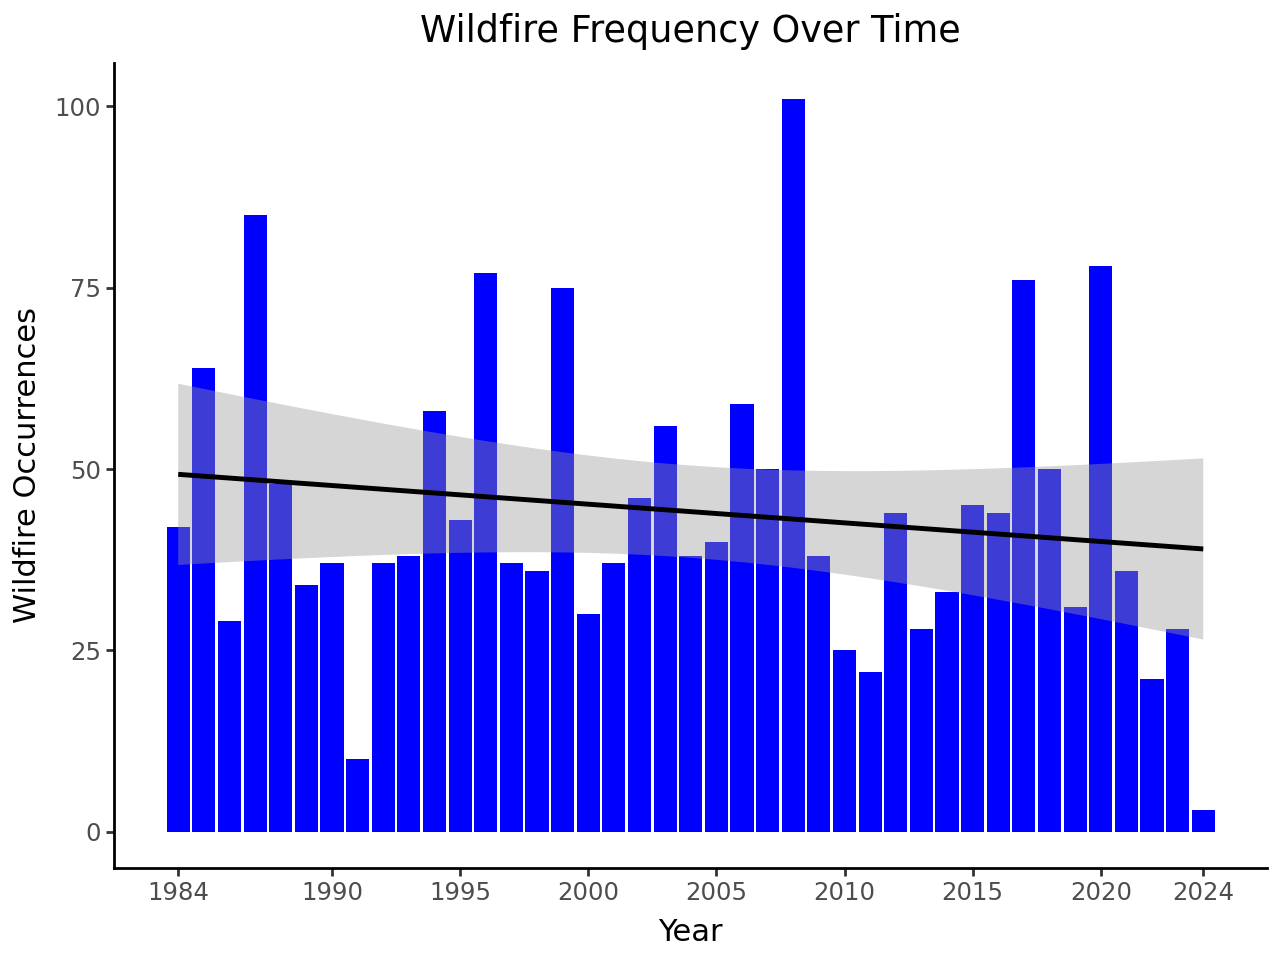

In [ ]:
(
    ggplot(CA_df_years, aes(x = 'Year', y='Wildfires'))
       + geom_bar(stat = 'identity', fill = 'blue')
       + geom_smooth(method='lm')
       + xlab("Year")
       + ylab("Wildfire Occurrences")
       + ggtitle("Wildfire Frequency Over Time")
       + scale_x_continuous(breaks = [1984, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2024])
       + theme_classic()

)

California Wildfire Size

In [ ]:
CA_df_acres = CA_df.pivot_table(index = 'Year', values = 'BurnBndAc', aggfunc = 'sum')
CA_df_acres['BurnBndAc'] = CA_df_acres['BurnBndAc'].astype(int)
CA_df_acres['BurnBndAc'] = CA_df_acres['BurnBndAc'] / 1000000
CA_df_acres = CA_df_acres.reset_index()
CA_df_acres.head()

,Year,BurnBndAc
0,1984,0.174275
1,1985,0.558454
2,1986,0.093186
3,1987,0.791185
4,1988,0.230920


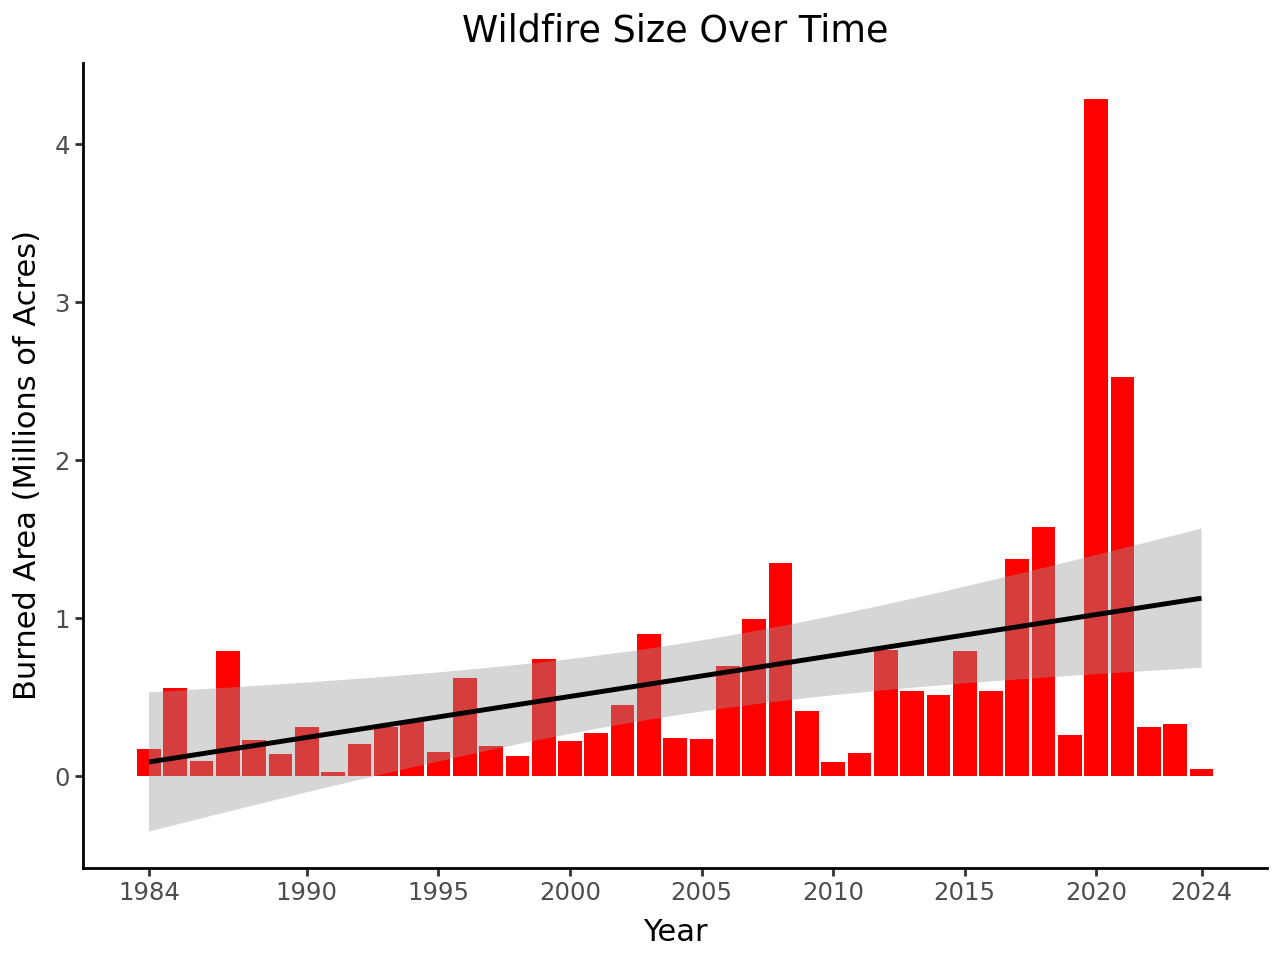

In [ ]:
# fire size over time
(
    ggplot(CA_df_acres, aes(x = 'Year', y='BurnBndAc'))
       + geom_bar(stat = 'identity', fill = 'red')
       + geom_smooth(method='lm')
       + xlab("Year")
       + ylab("Burned Area (Millions of Acres)")
       + ggtitle("Wildfire Size Over Time")
       + scale_x_continuous(breaks = [1984, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2024])
       + scale_y_continuous()
       + theme_classic()
)

Alaska

Alaska Wildfire Map

In [ ]:
#call Alaska boundary
alaska = df_states[df_states['NAME'] == 'Alaska']

In [ ]:
#Limit df to Alaska
AK_df = df_columns[df_columns['State'] == 'AK']

AK_df.head()

,State,Incid_Name,Incid_Type,BurnBndAc,BurnBndLat,BurnBndLon,Ig_Date,dNBR_offst,NoData_T,IncGreen_T,Low_T,Mod_T,High_T,geometry,Year
0,AK,CAMELBACK,Wildfire,4780,62.603,-157.421,1985-08-01,27.0,-970,-150,130,334,585,"POLYGON ((-157.44988 62.62182, -157.44895 62.6...",1985
1,AK,SUGARLOAF,Wildfire,5489,62.562,-156.645,1985-07-20,3.0,-970,-150,70,320,600,"POLYGON ((-156.69736 62.57441, -156.70027 62.5...",1985
2,AK,TAL NW 44,Wildfire,1491,65.476,-153.829,1985-08-01,14.0,-970,-150,50,275,530,"POLYGON ((-153.84454 65.46265, -153.84574 65.4...",1985
3,AK,GAL NE 48,Wildfire,1298,65.210,-155.265,1985-08-03,14.0,-970,-150,100,321,580,"POLYGON ((-155.27031 65.22507, -155.26915 65.2...",1985
19,AK,GAL NE 57,Wildfire,33126,65.439,-155.451,1985-07-13,4.0,-970,-150,70,414,775,"POLYGON ((-155.43668 65.49182, -155.43351 65.4...",1985


In [ ]:
#Set CRS
AK_df = AK_df.to_crs(epsg=4269)

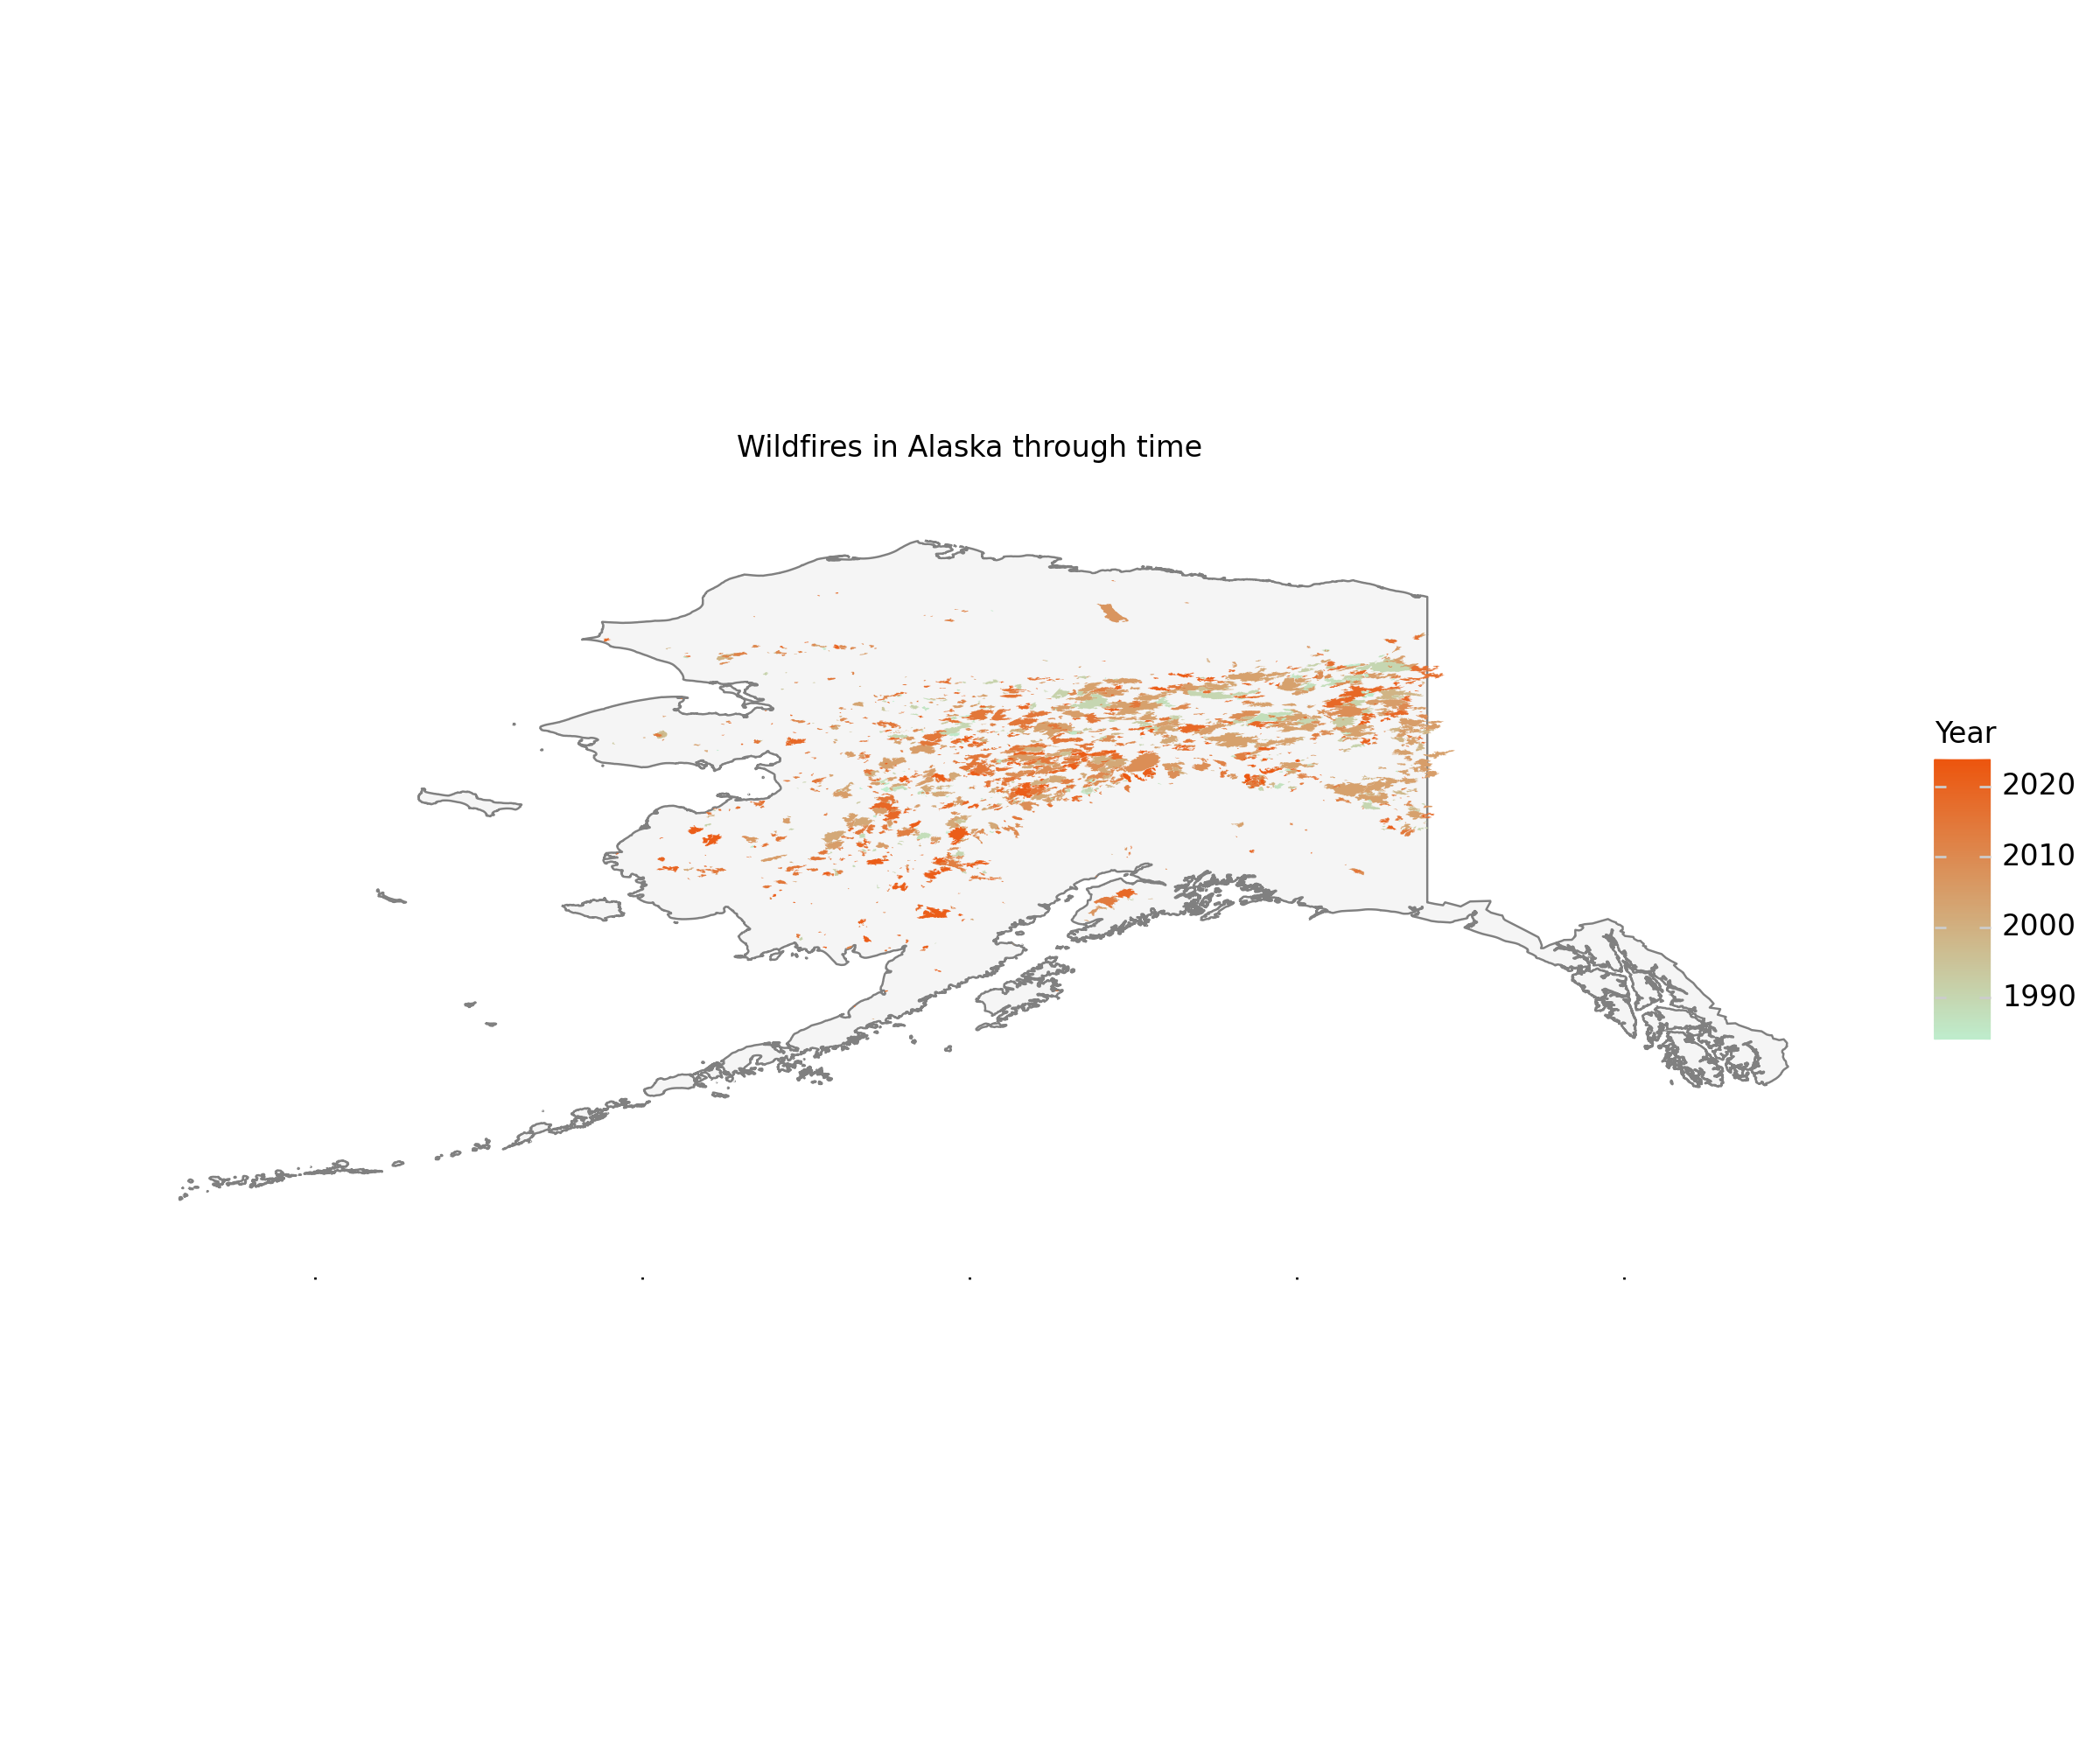

In [ ]:
#plot all AK fires according to severity
plotnine.options.figure_size = (12, 10)

(ggplot()
  + geom_map(alaska, fill='whitesmoke', color='grey')
  + geom_map(AK_df, aes(geometry='geometry', fill='Year'), color='#FF000000')
  + scale_fill_gradientn(colors=["#beedcd", "#ed550e"], limits=[1984, 2024])
  + labs(fill='Year')
  + ggtitle("Wildfires in Alaska through time")
  + theme_classic()
  + theme(
      axis_line=element_line(color="white"),
      axis_ticks=element_line(color="white"),
      axis_text=element_line(color='white'),
      text=element_text(size=12)
  )
  + coord_fixed(xlim=[-180, -130], ylim=[50, 72])
)

Alaska Wildfire Frequency

In [ ]:
# bucket by year
AK_df_years = AK_df.pivot_table(index = 'Year', values = 'Incid_Type', aggfunc = 'count')
AK_df_years = AK_df_years.rename(columns = {'Incid_Type': 'Wildfires'})
AK_df_years = AK_df_years.reset_index()
AK_df_years.head()

,Year,Wildfires
0,1984,19
1,1985,22
2,1986,36
3,1987,14
4,1988,22


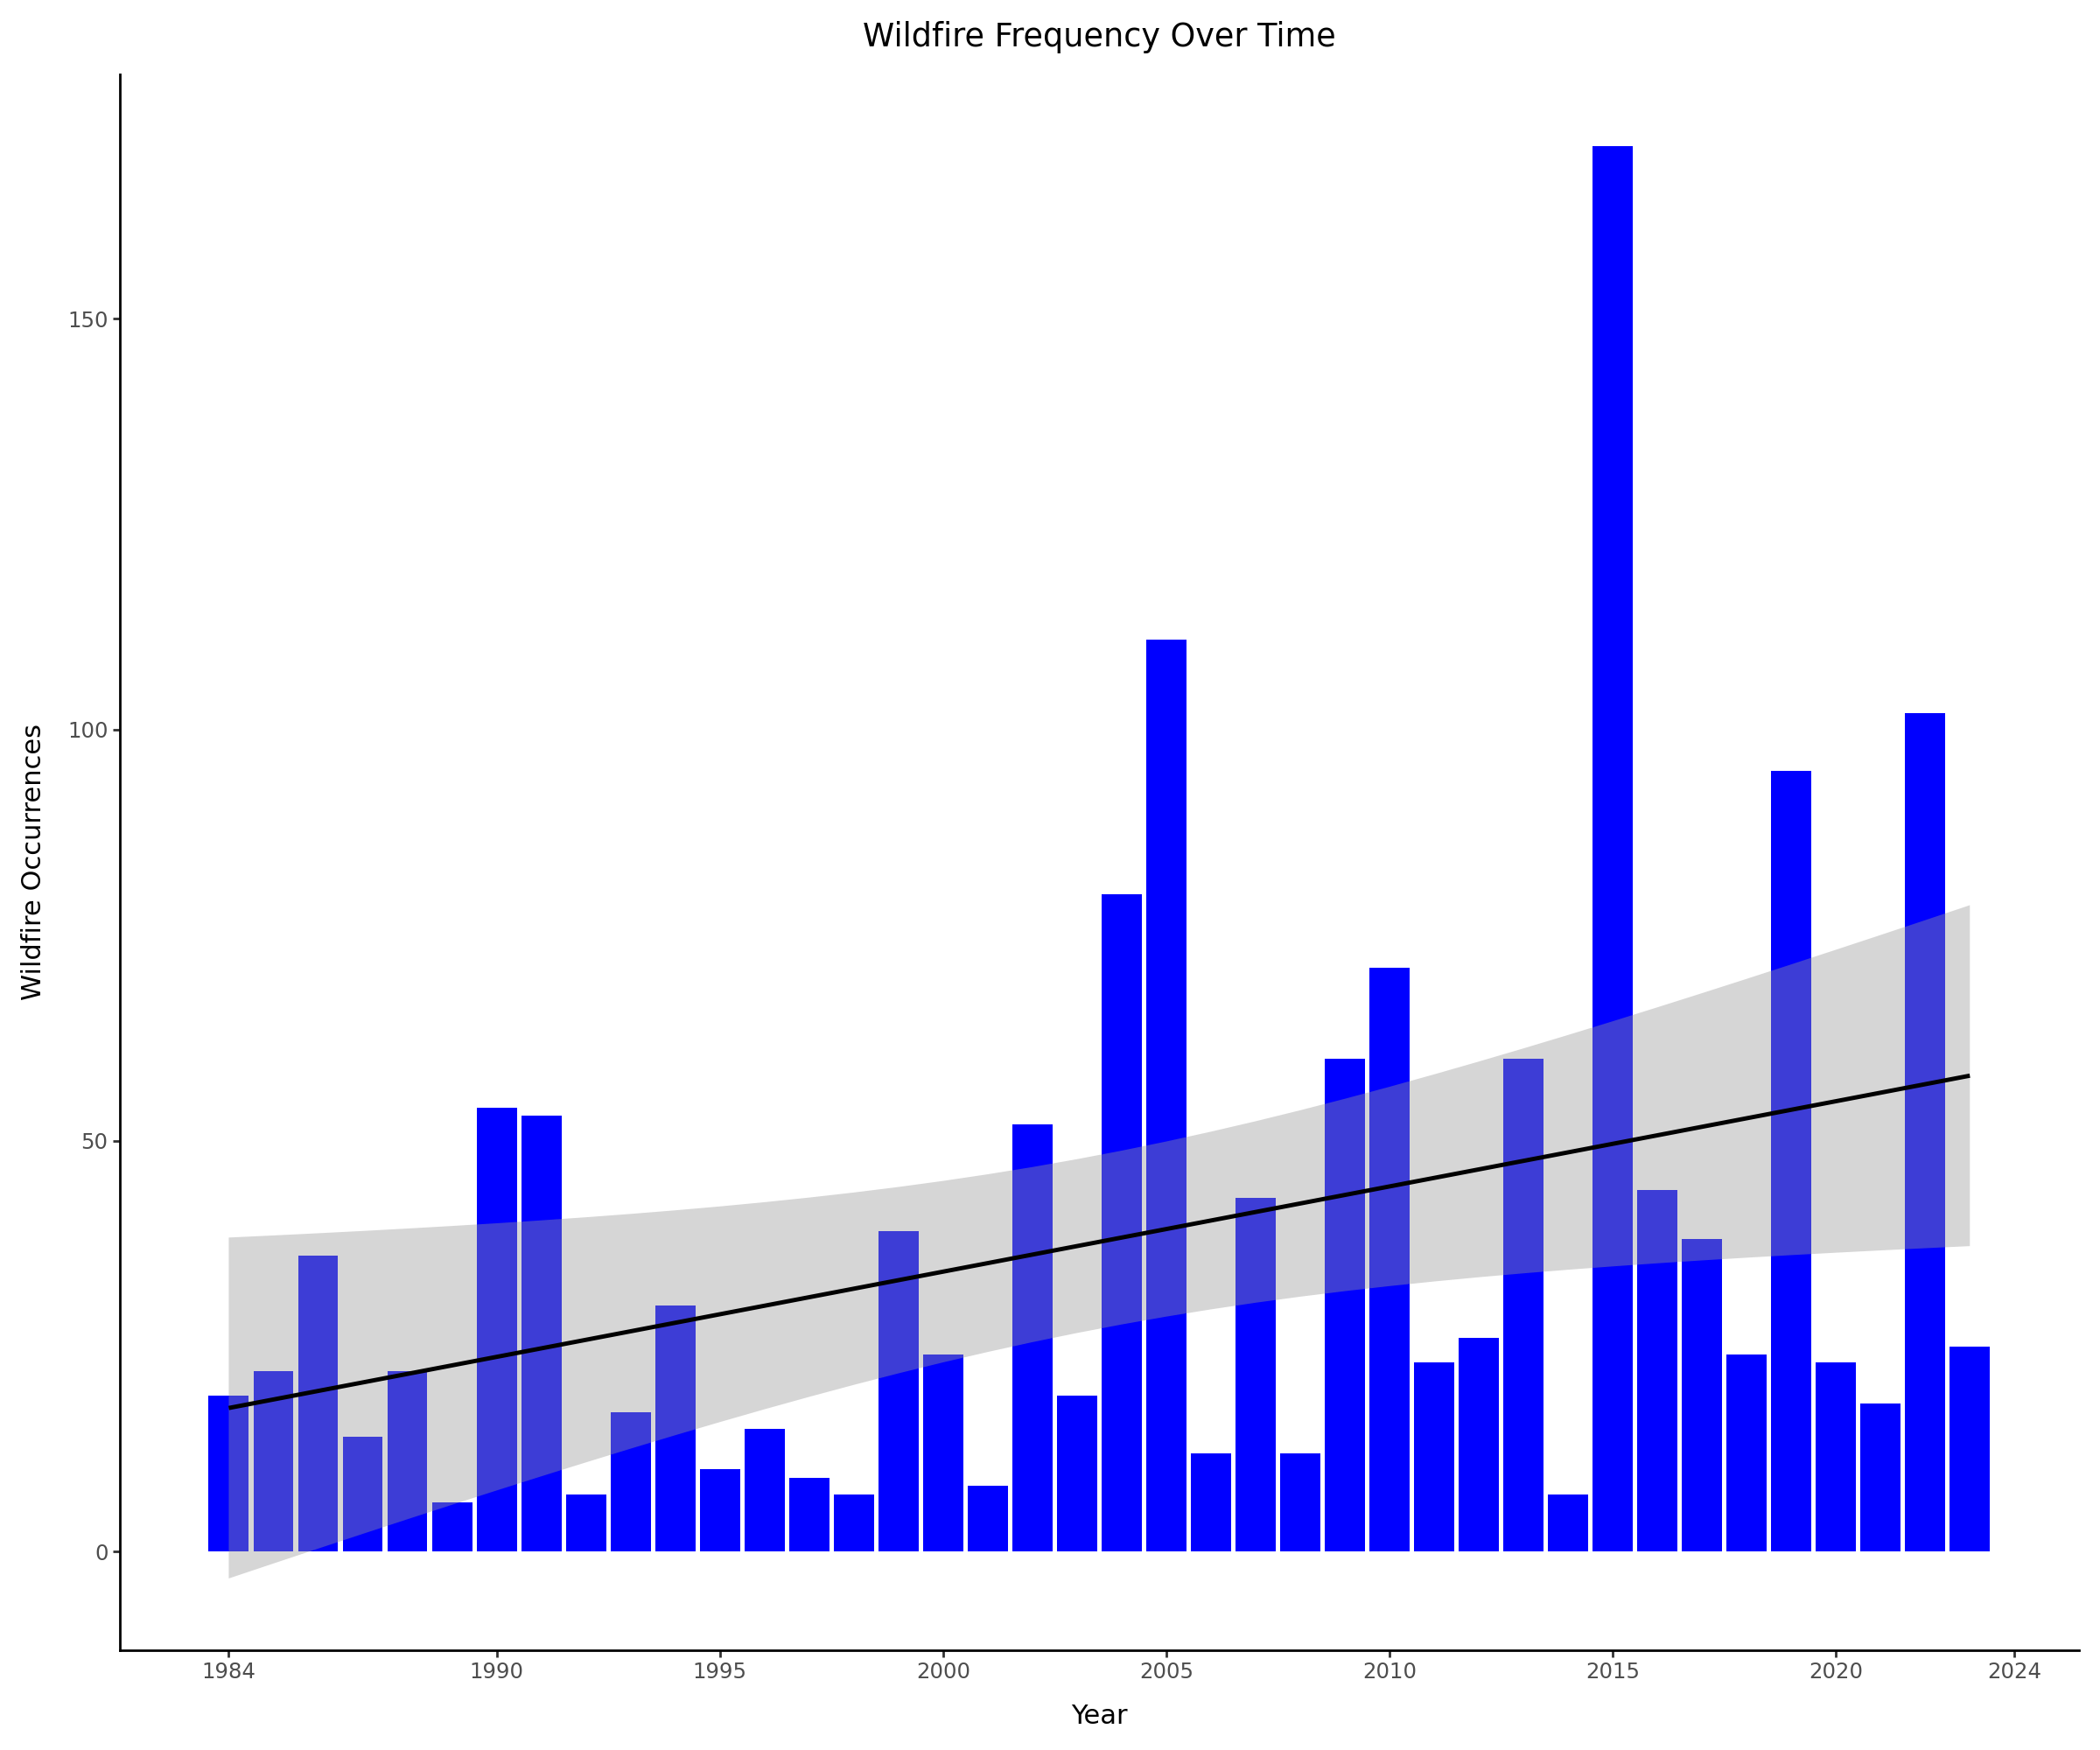

In [ ]:
(
    ggplot(AK_df_years, aes(x = 'Year', y='Wildfires'))
       + geom_bar(stat = 'identity', fill = 'blue')
       + geom_smooth(method='lm')
       + xlab("Year")
       + ylab("Wildfire Occurrences")
       + ggtitle("Wildfire Frequency Over Time")
       + scale_x_continuous(breaks = [1984, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2024])
       + theme_classic()

)

Alaska Wildfire Size

In [ ]:
AK_df_acres = AK_df.pivot_table(index = 'Year', values = 'BurnBndAc', aggfunc = 'sum')
AK_df_acres['BurnBndAc'] = AK_df_acres['BurnBndAc'].astype(int)
AK_df_acres['BurnBndAc'] = AK_df_acres['BurnBndAc'] / 1000000
AK_df_acres = AK_df_acres.reset_index()
AK_df_acres.head()

,Year,BurnBndAc
0,1984,0.097965
1,1985,0.334662
2,1986,0.313788
3,1987,0.110934
4,1988,0.901222


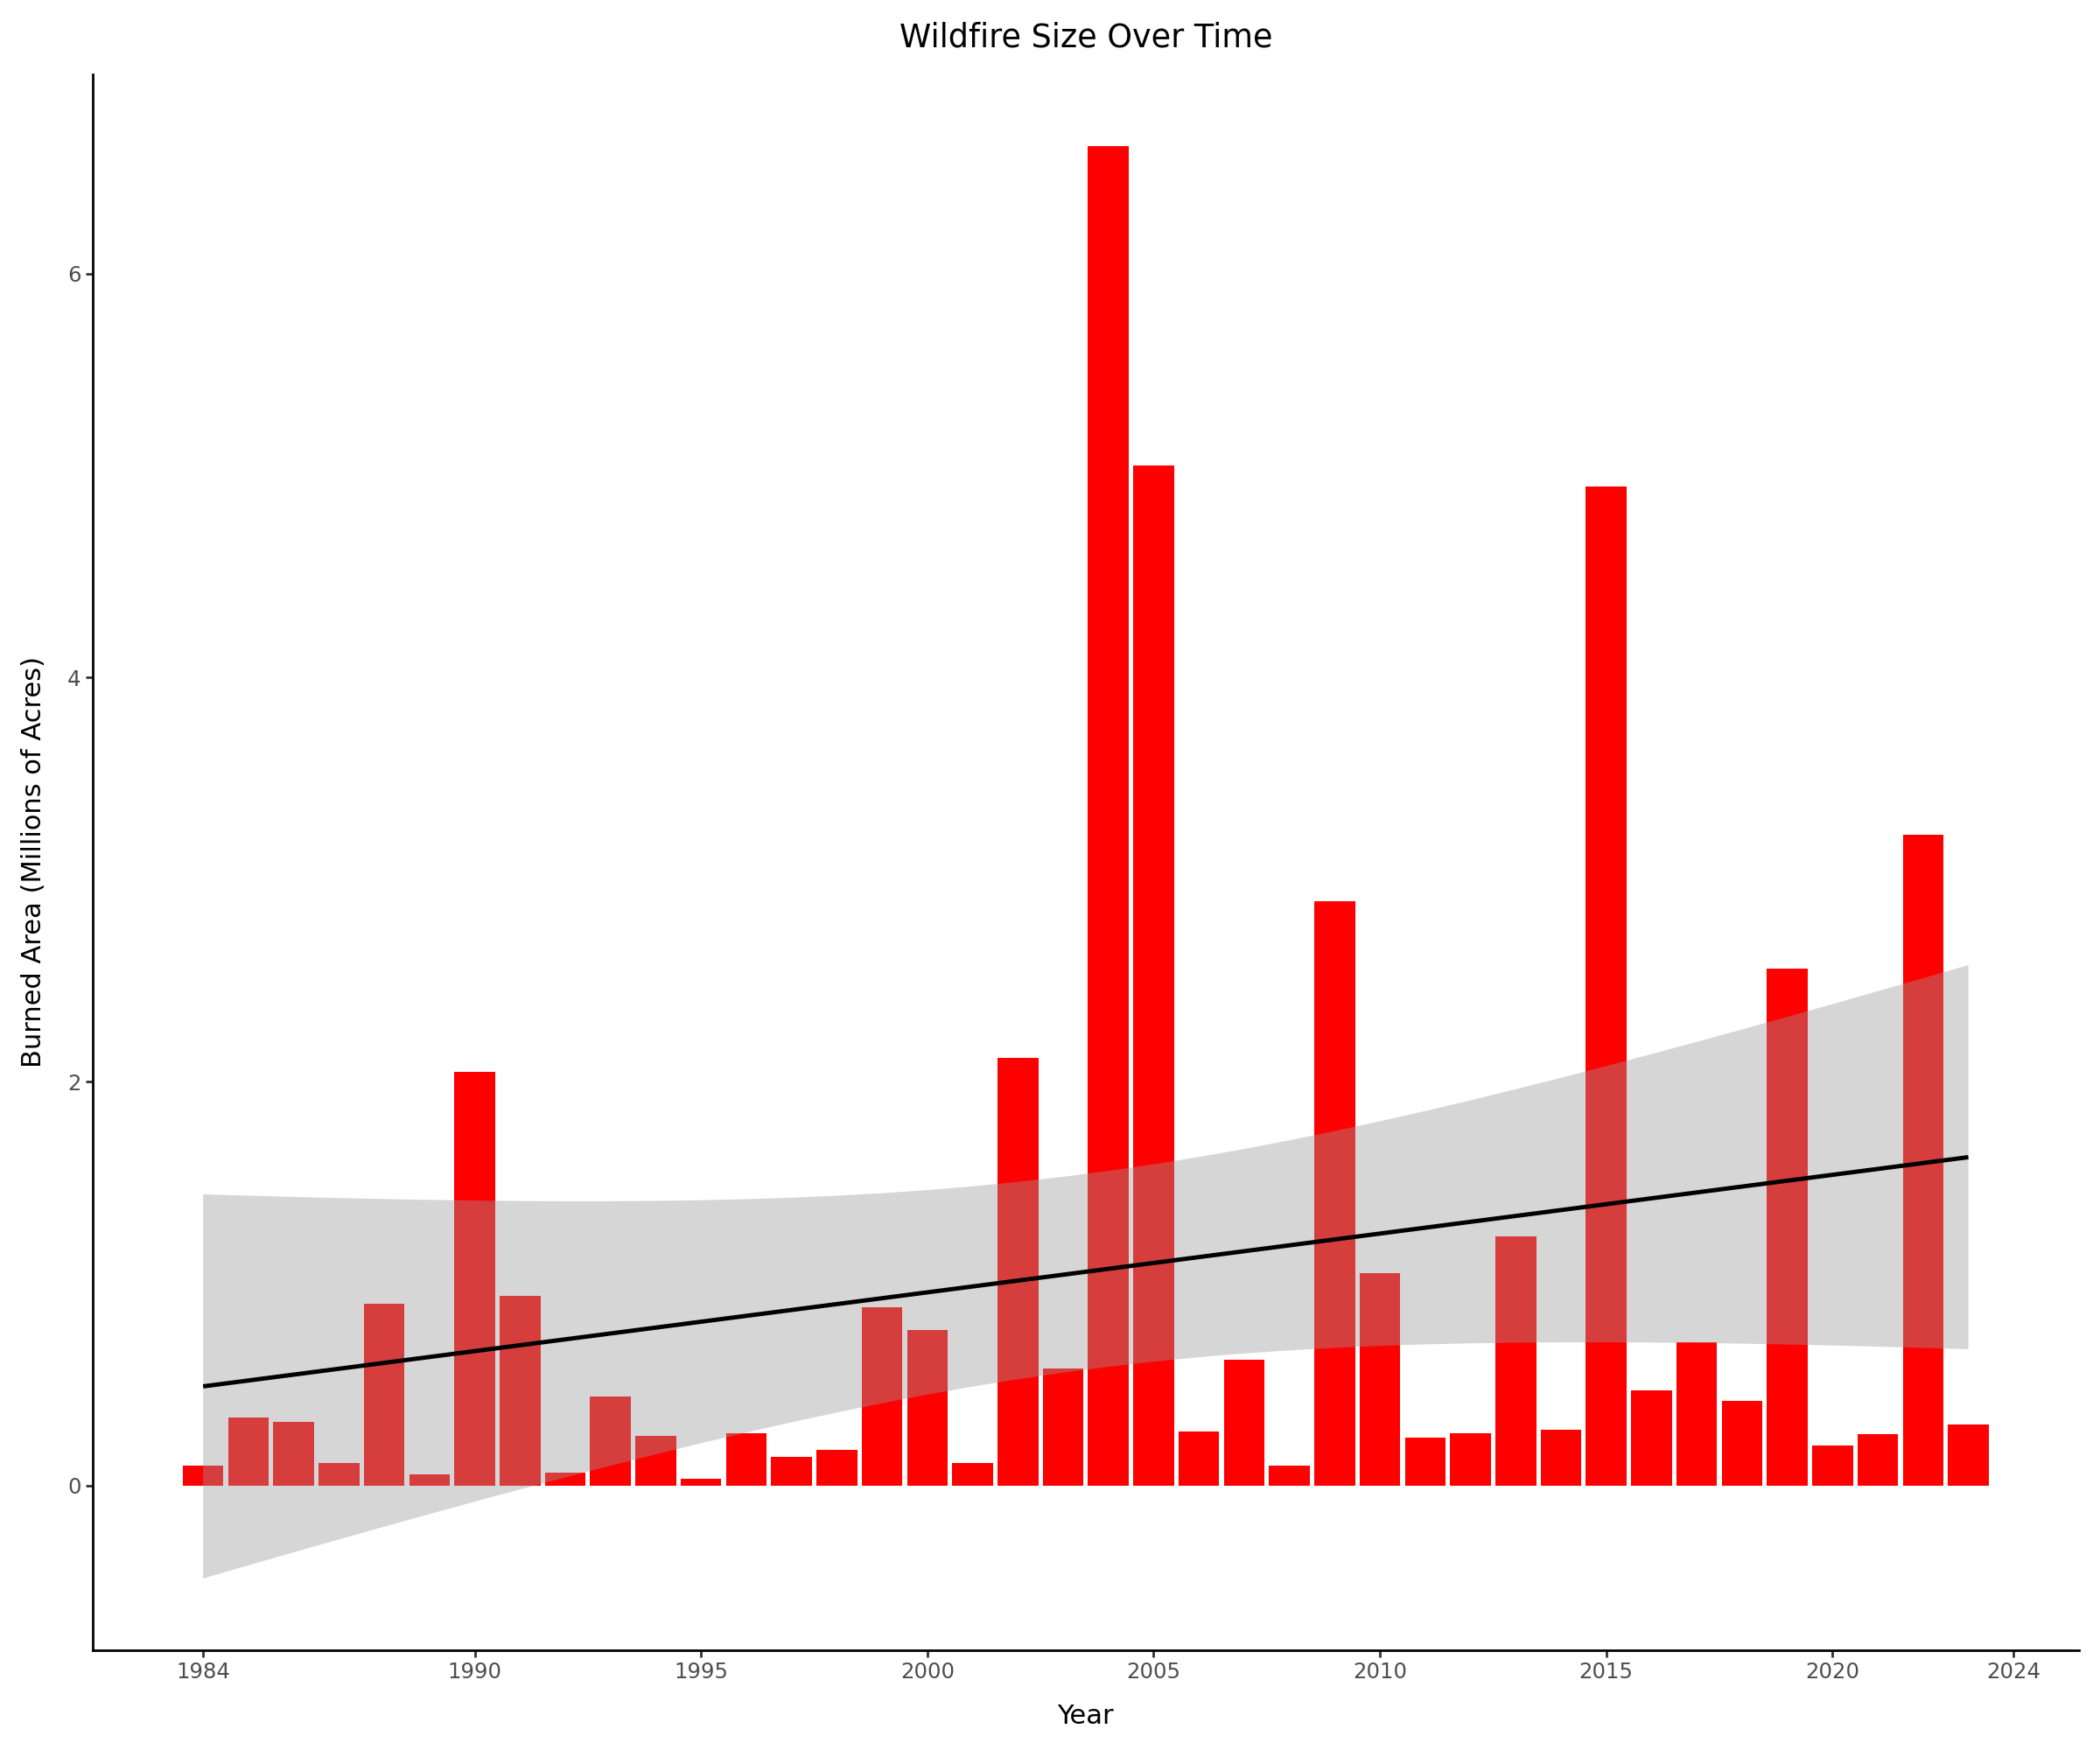

In [ ]:
# fire size over time
(
    ggplot(AK_df_acres, aes(x = 'Year', y='BurnBndAc'))
       + geom_bar(stat = 'identity', fill = 'red')
       + geom_smooth(method='lm')
       + xlab("Year")
       + ylab("Burned Area (Millions of Acres)")
       + ggtitle("Wildfire Size Over Time")
       + scale_x_continuous(breaks = [1984, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2024])
       + scale_y_continuous()
       + theme_classic()
)

Nevada

Nevada Wildfire Map

In [ ]:
#call Nevada boundary
nevada = df_states[df_states['NAME'] == 'Nevada']

In [ ]:
#Limit df to Nevada
NV_df = df_columns[df_columns['State'] == 'NV']

NV_df.head()

,State,Incid_Name,Incid_Type,BurnBndAc,BurnBndLat,BurnBndLon,Ig_Date,dNBR_offst,NoData_T,IncGreen_T,Low_T,Mod_T,High_T,geometry,Year
44,NV,DRY VALLEY,Wildfire,15749,40.246,-119.894,1985-06-19,20.0,-970,-150,55,126,250,"POLYGON ((-119.93797 40.26402, -119.93713 40.2...",1985
89,NV,COTTONWOOD,Wildfire,16877,40.128,-117.091,1985-07-07,46.0,-970,-150,130,262,450,"POLYGON ((-117.1591 40.0655, -117.15924 40.065...",1985
90,NV,FIRE CREEK,Wildfire,15527,40.537,-116.556,1985-07-10,42.0,-970,-150,100,9999,9999,"POLYGON ((-116.6314 40.51879, -116.63085 40.51...",1985
91,NV,BEDEL FLAT,Wildfire,9490,39.839,-119.754,1985-07-18,-19.0,-970,-150,-10,180,9999,"POLYGON ((-119.76346 39.88091, -119.76204 39.8...",1985
92,NV,COCOON MTS,Wildfire,8000,39.220,-118.519,1985-07-29,38.0,-970,-150,120,200,9999,"POLYGON ((-118.53423 39.25839, -118.53373 39.2...",1985


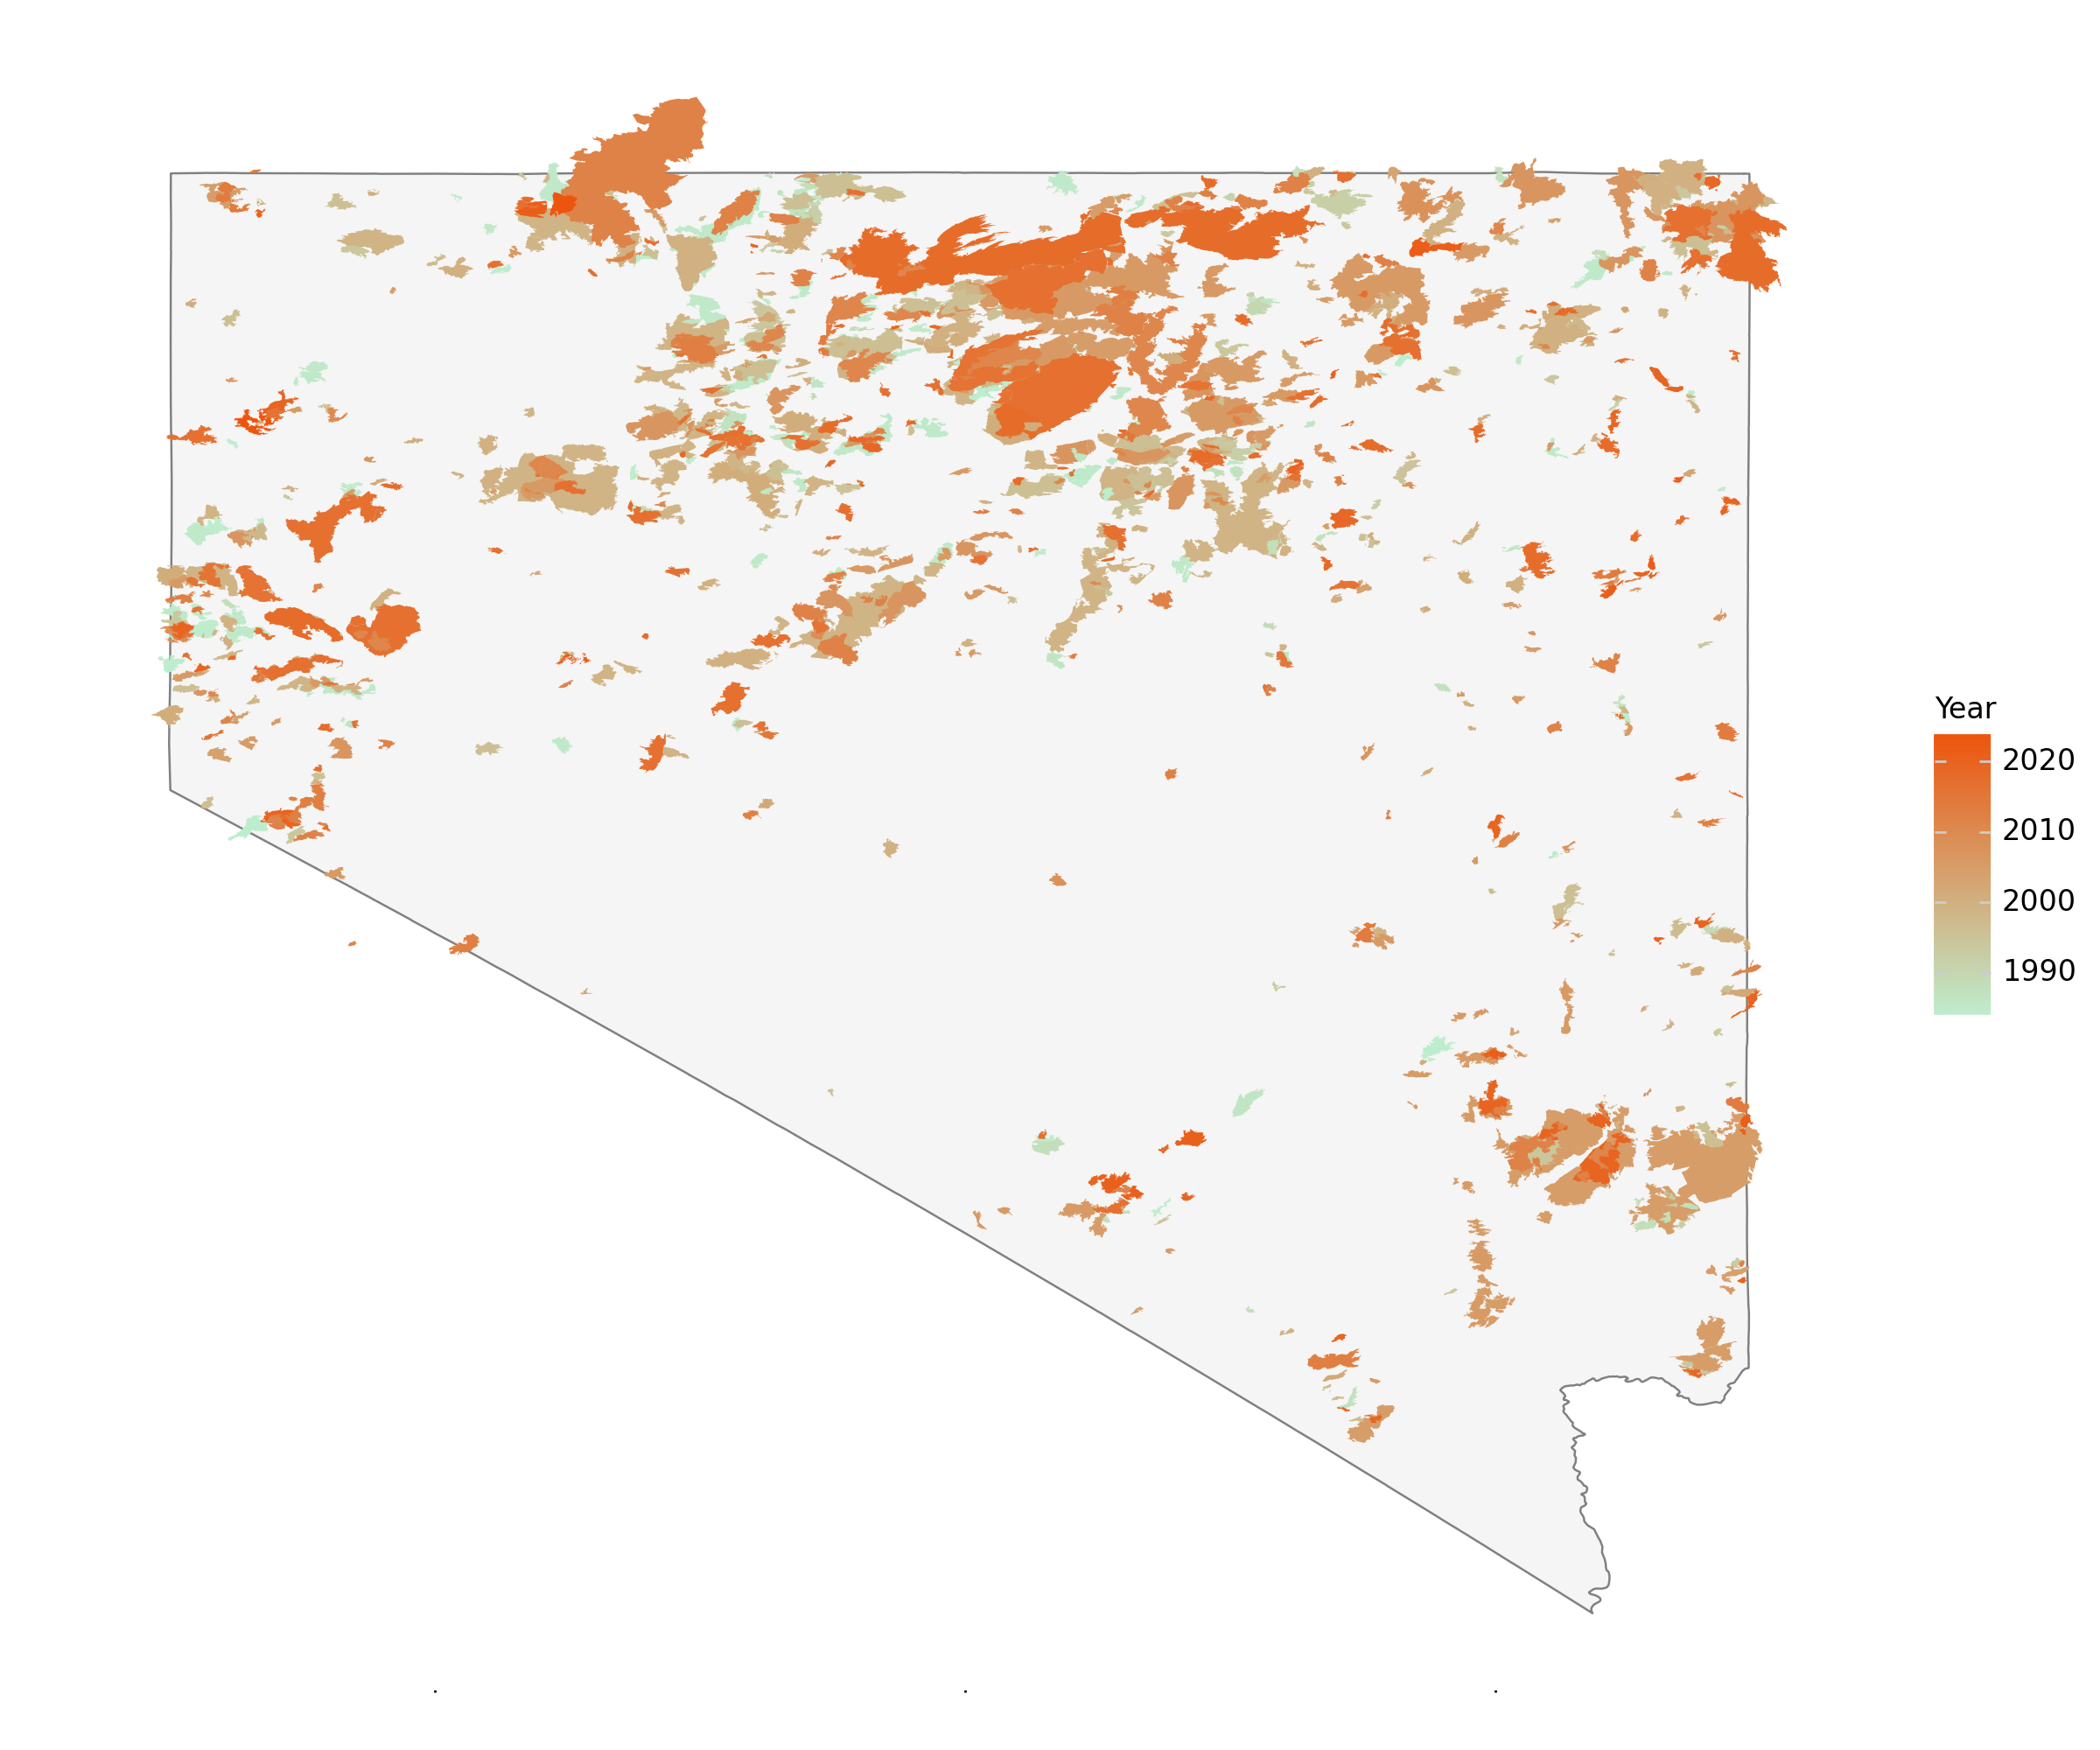

In [ ]:
#plot all CA fires according to severity
(ggplot()
  + geom_map(nevada, fill= 'whitesmoke', color = 'grey')
  + geom_map(NV_df, aes(geometry = 'geometry', fill = 'Year'), color = '#FF000000')
  + scale_fill_gradientn(colors = ["#beedcd", "#ed550e"],limits = [1984, 2024])
  + labs(fill='Year')
  + theme_classic()
  + theme(axis_line=element_line(color="white"),
          axis_ticks=element_line(color = "white"),
          axis_text=element_line(color='white'),
          text=element_text(size = 12))
  # + xlab("")
  # + ylab("")
 )

Nevada Wildfire Frequency

In [ ]:
# bucket by year
NV_df_years = NV_df.pivot_table(index = 'Year', values = 'Incid_Type', aggfunc = 'count')
NV_df_years = NV_df_years.rename(columns = {'Incid_Type': 'Wildfires'})
NV_df_years = NV_df_years.reset_index()
NV_df_years.head()

,Year,Wildfires
0,1984,29
1,1985,72
2,1986,19
3,1987,19
4,1988,19


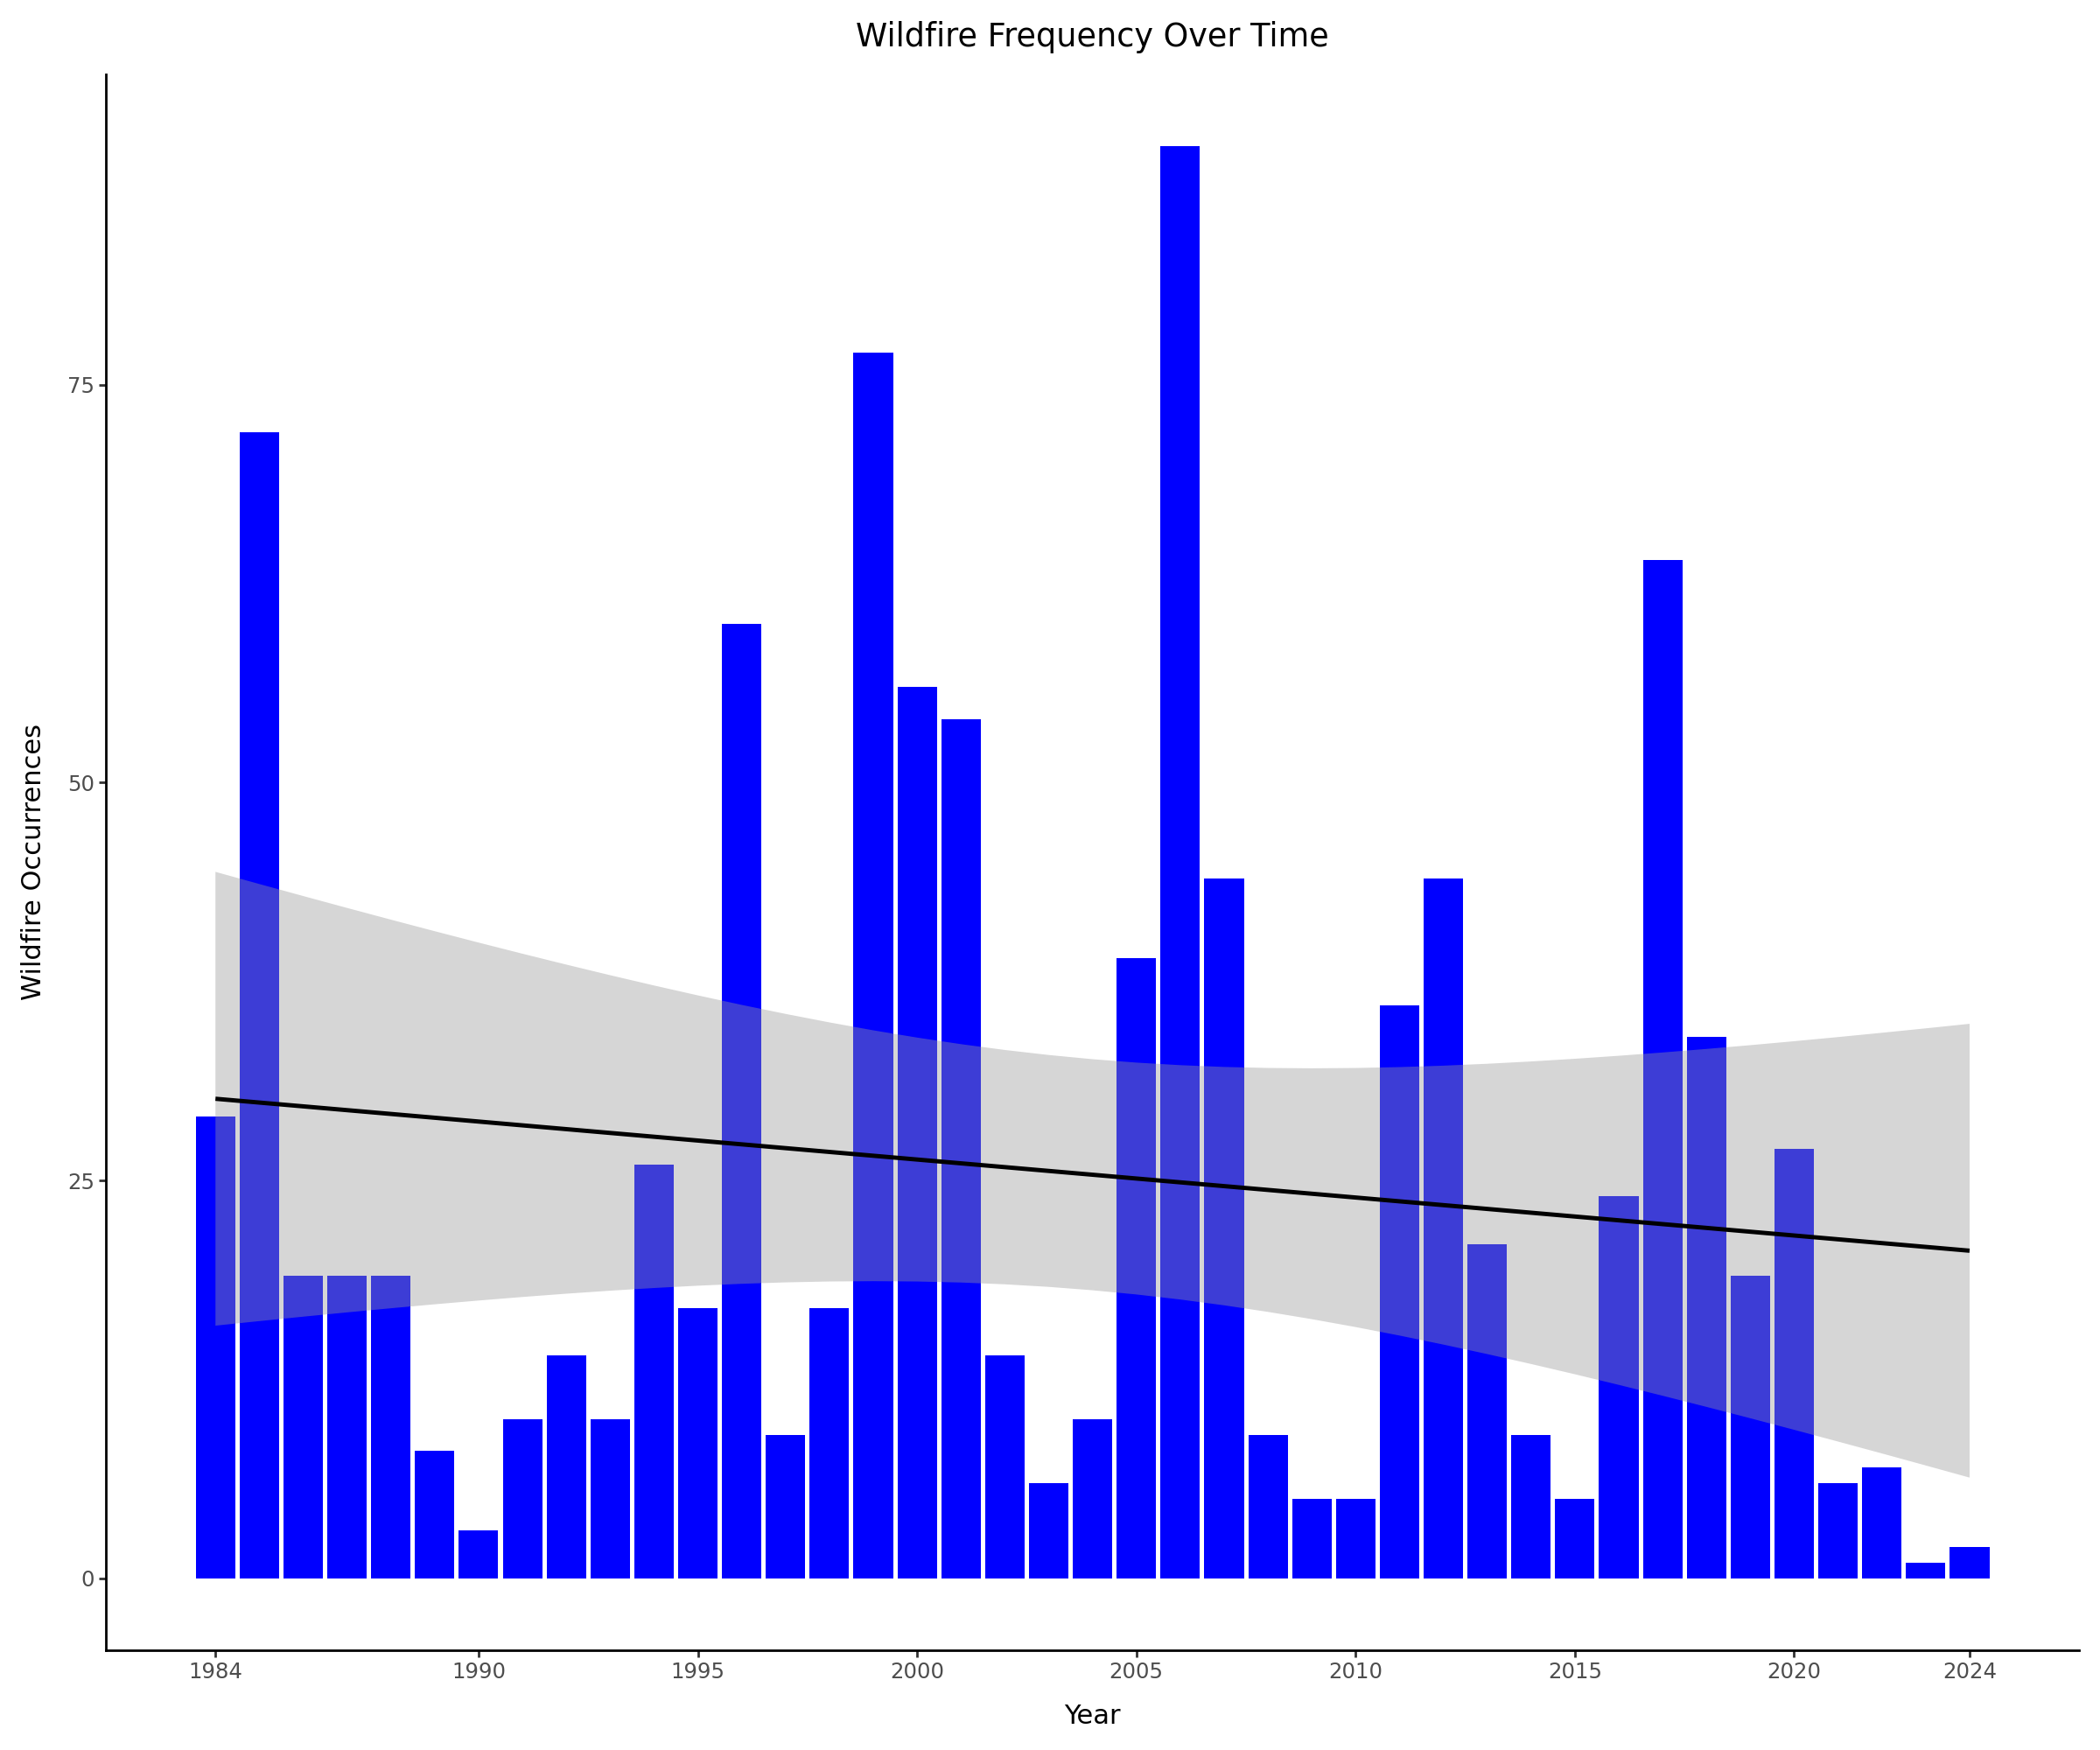

In [ ]:
(
    ggplot(NV_df_years, aes(x = 'Year', y='Wildfires'))
       + geom_bar(stat = 'identity', fill = 'blue')
       + geom_smooth(method='lm')
       + xlab("Year")
       + ylab("Wildfire Occurrences")
       + ggtitle("Wildfire Frequency Over Time")
       + scale_x_continuous(breaks = [1984, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2024])
       + theme_classic()

)

Nevada Wildfire Size

In [ ]:
NV_df_acres = NV_df.pivot_table(index = 'Year', values = 'BurnBndAc', aggfunc = 'sum')
NV_df_acres['BurnBndAc'] = NV_df_acres['BurnBndAc'].astype(int)
NV_df_acres['BurnBndAc'] = NV_df_acres['BurnBndAc'] / 1000000
NV_df_acres = NV_df_acres.reset_index()
NV_df_acres.head()

,Year,BurnBndAc
0,1984,0.218695
1,1985,0.816311
2,1986,0.101973
3,1987,0.073576
4,1988,0.085713


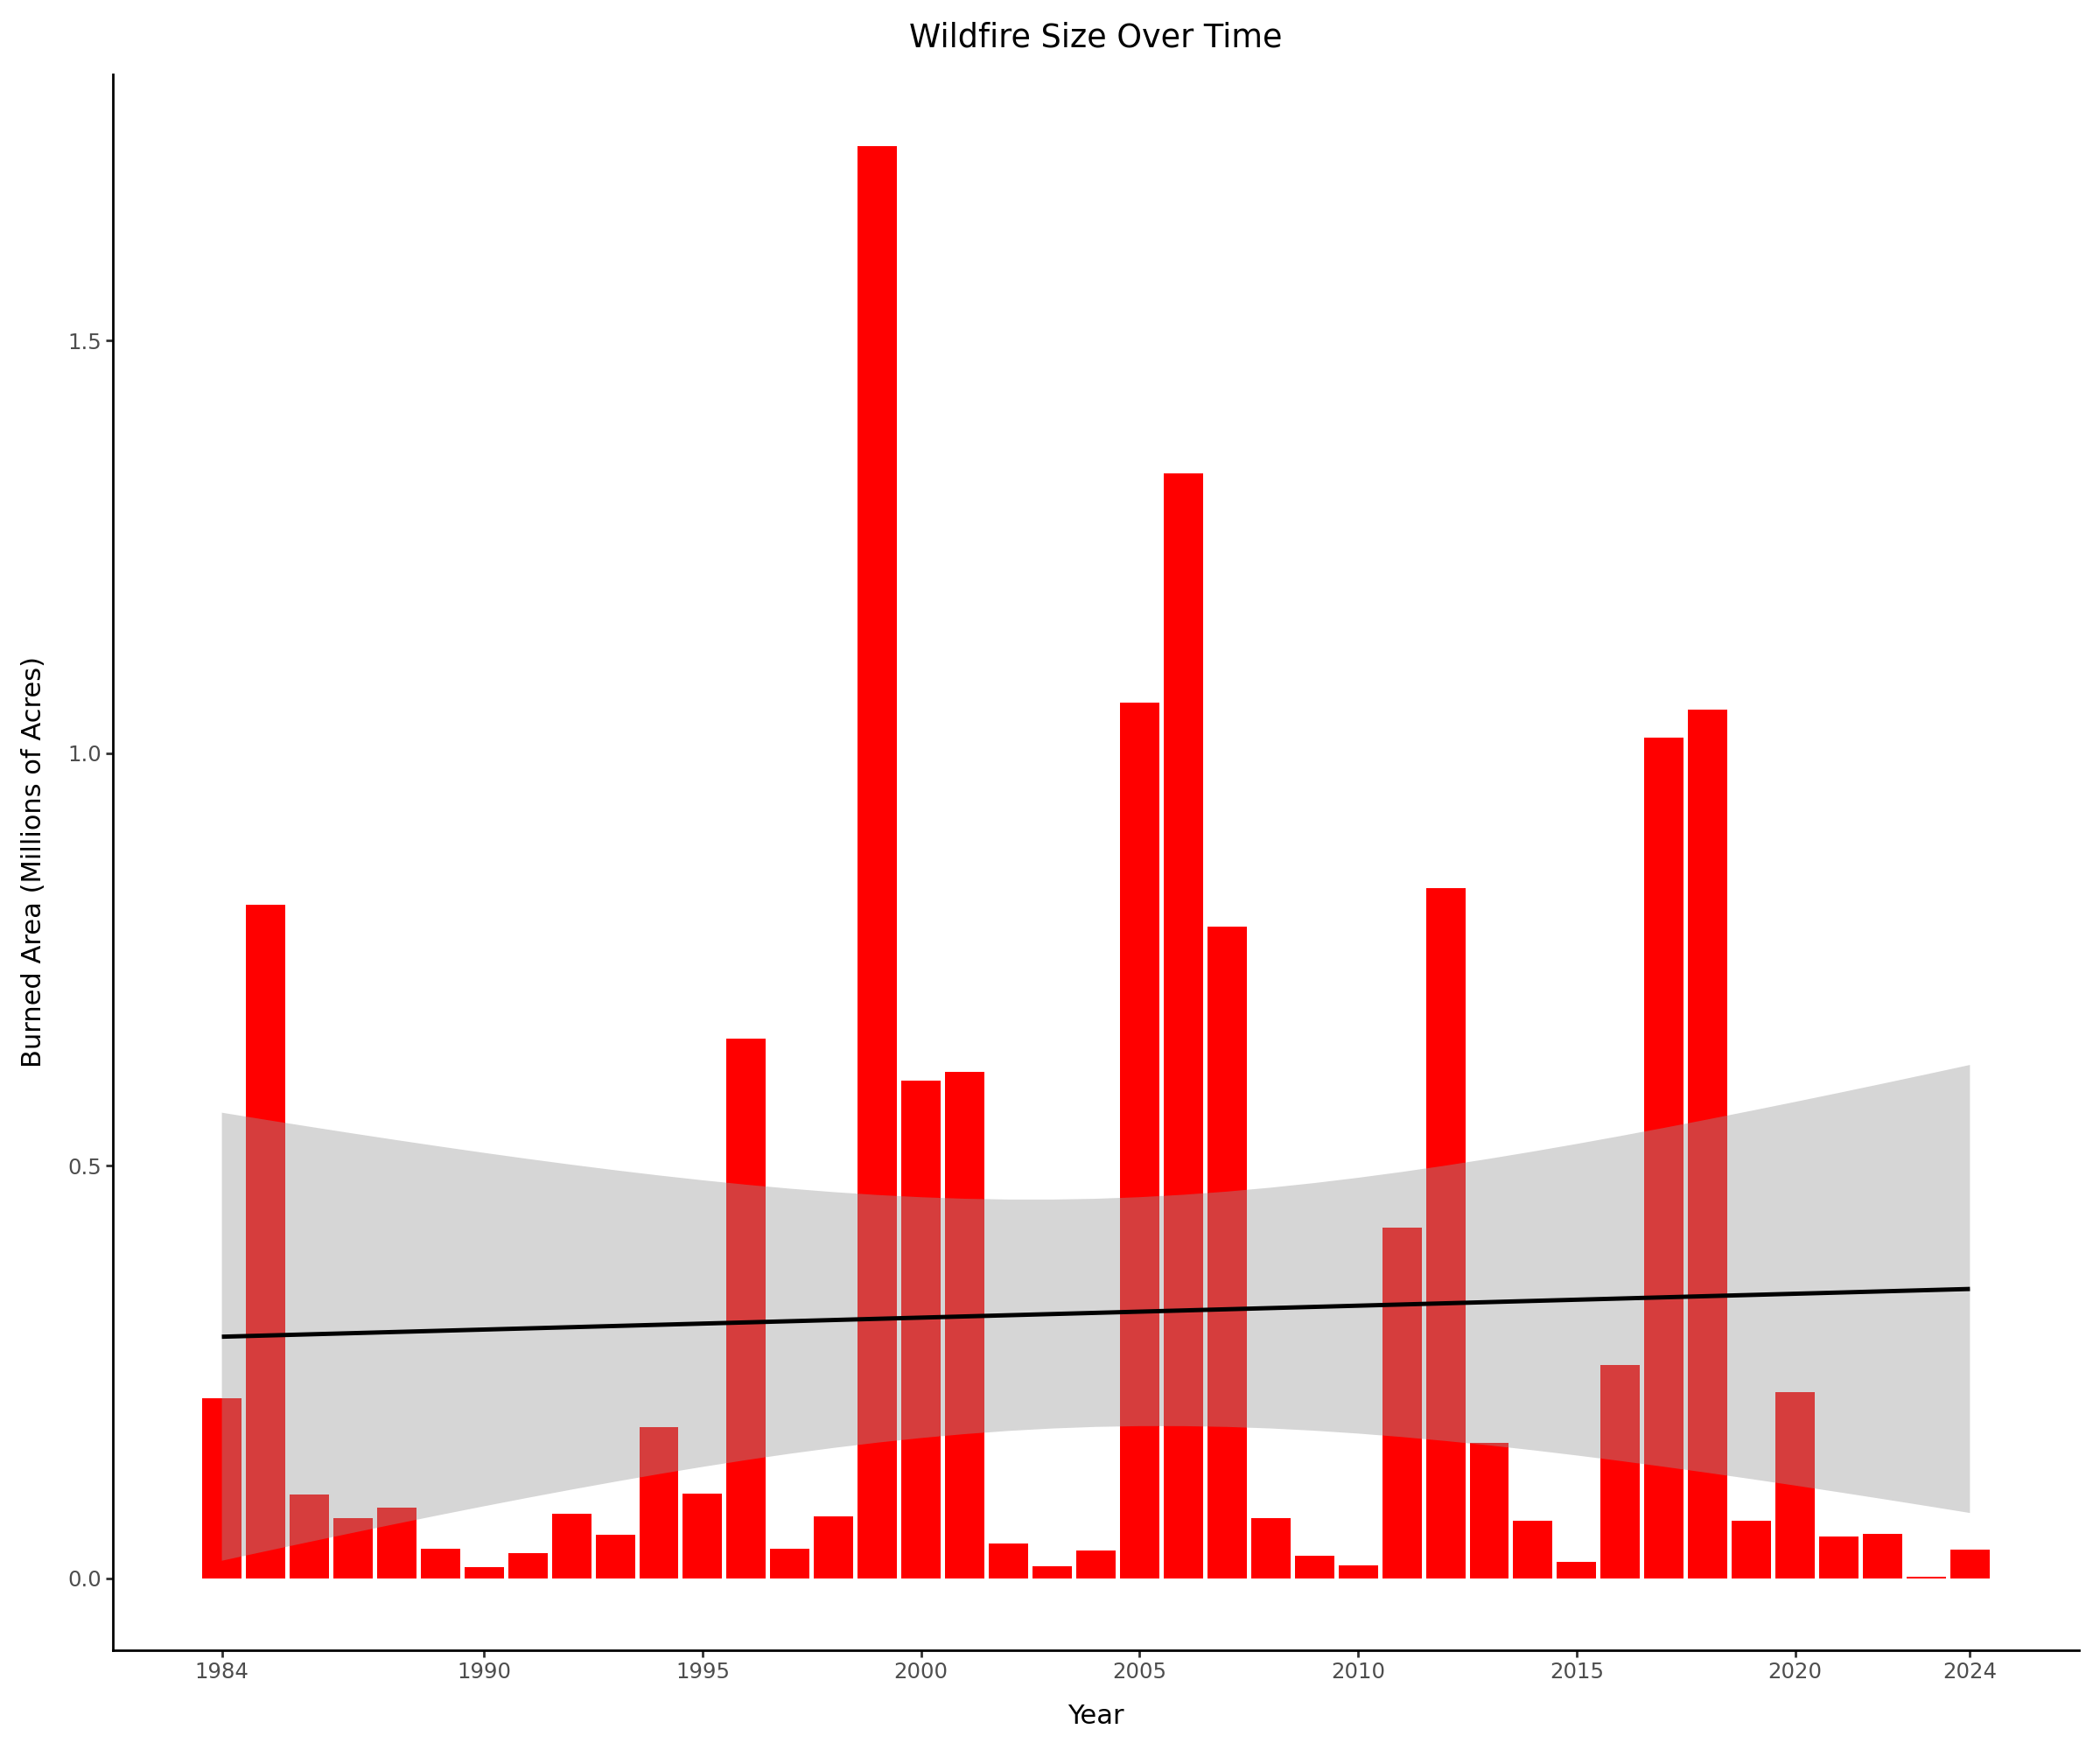

In [ ]:
# fire size over time
(
    ggplot(NV_df_acres, aes(x = 'Year', y='BurnBndAc'))
       + geom_bar(stat = 'identity', fill = 'red')
       + geom_smooth(method='lm')
       + xlab("Year")
       + ylab("Burned Area (Millions of Acres)")
       + ggtitle("Wildfire Size Over Time")
       + scale_x_continuous(breaks = [1984, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2024])
       + scale_y_continuous()
       + theme_classic()
)

#Create State Animation

To visualize how fire placement has changed over time and practice some new Python skills, we create a GIF presenting each year of California's wildfire coverage.

In [ ]:
#define years for animation
years = sorted(df_wildfires['Year'].unique())

In [ ]:
#Define animation constants
OUTPUT_DIR = "frames" #create directory to hold frames
CA_GIF = "map_animation.gif" #create final output file
FIG_WIDTH = 10 #set standard size for each animation frame
FIG_HEIGHT = 8 #set standard size for each animation frame
DPI = 100 #set standard resolution
FPS = 2 #set frames per second

In [ ]:
#create CA frame boundary
min_x, min_y, max_x, max_y = california.total_bounds

#create 5% buffer around frame to avoid cutoff
buffer_x = (max_x - min_x) * 0.05
buffer_y = (max_y - min_y) * 0.05

#extend CA frame boundary using buffer
min_x -= buffer_x
min_y -= buffer_y
max_x += buffer_x
max_y += buffer_y

In [ ]:
#create a png for each year

frame_paths = [] #create empty vector to fill

if not os.path.exists(OUTPUT_DIR): #make output directory for each frame
    os.makedirs(OUTPUT_DIR)

for year in years: #create frame for individual year
    frame_path = os.path.join(OUTPUT_DIR, f"frame_{year}.png") # create filenames
    frame_paths.append(frame_path) # add each new frame to vector

    # Generate plot for year
    fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT))
    year_df = CA_df[CA_df['Year'] == year]

    # Add California boundaries
    california.boundary.plot(ax=ax, color='#e6e6e6', linewidth=1) #plot boundary
    california.plot(ax=ax, color='lightgray', alpha=0.5) # fill with light gray

    # Plot the data if there is any for this year
    if not year_df.empty:
        year_df.plot(column='Year', ax=ax,
                    cmap=plt.cm.RdYlGn_r,
                    vmin=1984, vmax=2024,
                    edgecolor='#FF000000',
                    legend=True)

    ax.set_xlim(min_x, max_x) #set defined axis limits with buffer
    ax.set_ylim(min_y, max_y) #set defined axis limits with buffer

    ax.set_title(f'Year: {year}', fontsize=14)      # Set dynamic title
    ax.axis('off')                                  # Remove axes
    plt.tight_layout()

    # Save to file
    plt.savefig(frame_path, dpi=DPI)
    plt.close(fig)

<ipython-input-67-30df5fd3e10c>:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


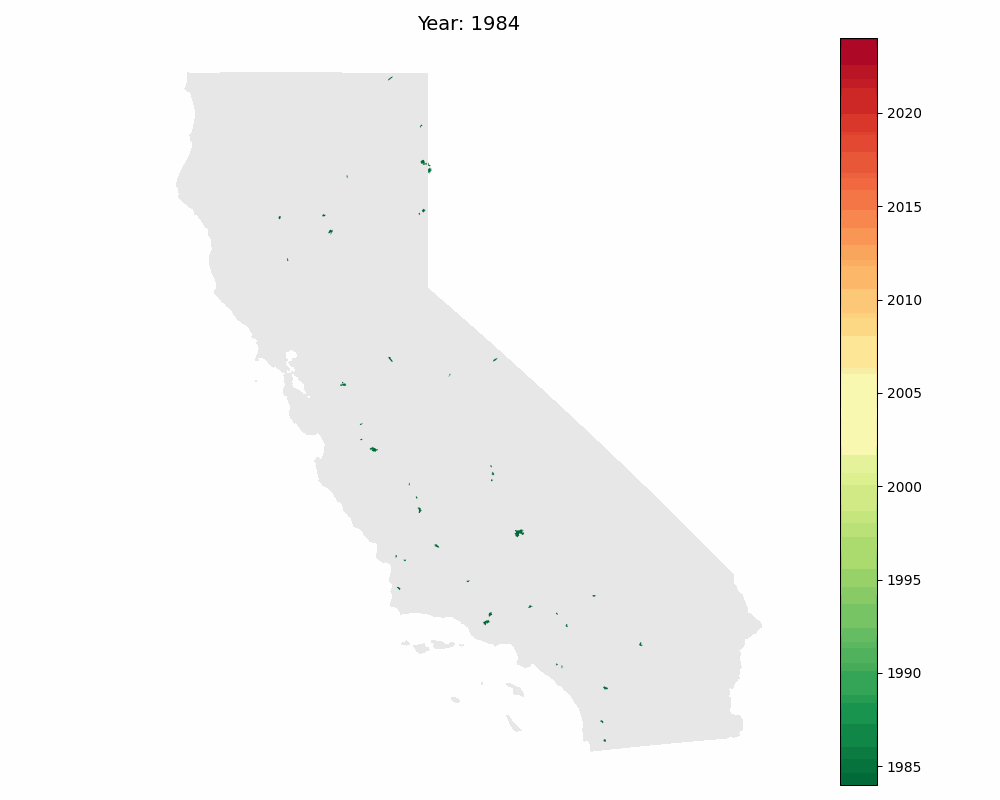

In [ ]:
#combine yearly pngs into gif using imageio

images = []
for path in frame_paths:
    images.append(imageio.imread(path))

imageio.mimsave(CA_GIF, images, fps=FPS) #fill CA_GIF with set of images

display(Image(filename=CA_GIF)) #show gif